# TRABAJO FIN DE GRADO - JAVIER FERNÁNDEZ GUERRA

### INTRODUCCIÓN

Este notebook constituye un complemento práctico al Trabajo de Fin de Grado titulado “Usos y Aplicaciones de la Inteligencia Artificial en los Mercados Financieros”. Su finalidad es ilustrar paso a paso el proceso de análisis, modelización y validación realizado en el estudio, sirviendo como soporte técnico a los contenidos desarrollados en la memoria escrita.

A lo largo del notebook se implementan algoritmos de clasificación supervisada como Decision Tree, Random Forest y XGBoost para la selección de acciones dentro del índice EuroStoxx 50. Se incorporan técnicas avanzadas de validación como backtesting con división temporal y métodos de optimización como los algoritmos genéticos, con el objetivo de evaluar el potencial del aprendizaje automático en la mejora de las decisiones de inversión.

Este documento está pensado para un lector interesado en los aspectos computacionales del trabajo, facilitando la comprensión de las decisiones metodológicas y la replicación de los resultados obtenidos.



### CUESTIONES PREVIAS

Antes de iniciar el análisis, se procede a preparar el entorno de trabajo mediante la instalación e importación de las librerías necesarias. Estas permiten cubrir distintas funciones clave a lo largo del estudio.

1) <u>Acceso a datos financieros</u>:  
Se utiliza la biblioteca `eikon` para la obtención de datos financieros históricos y en tiempo real. La API de LSEG Workspace (antiguo Refinitiv Eikon) requiere una clave de autenticación que debe proporcionarse al comienzo del notebook.

2) <u>Procesamiento y análisis de datos</u>:  
Las herramientas `pandas` y `numpy` permiten manejar estructuras de datos y realizar cálculos numéricos eficientes, fundamentales en el preprocesamiento y análisis exploratorio.

3) <u>Modelado estadístico y aprendizaje automático</u>:  
Se importan los modelos basados en árboles (`DecisionTree`, `RandomForest`, `XGBoost`) así como funciones de validación cruzada y escalado de datos incluidas en `scikit-learn`.

4) <u>Visualización</u>:  
Se emplean `matplotlib` y `seaborn` para la creación de gráficos y análisis visuales que facilitan la interpretación de los resultados obtenidos en las distintas etapas del análisis.

5) <u>Configuración para reproducibilidad</u>:  
Se establecen semillas aleatorias mediante `random` y `numpy` para asegurar que los resultados sean replicables en ejecuciones sucesivas. También se suprimen advertencias innecesarias que puedan dificultar la lectura de las salidas del notebook.

6) <u>Clave de acceso a Refinitiv</u>:  
Se configura la clave con la función `ek.set_app_key()`, que permite autenticar las consultas a la API de LSEG. Esta clave debe ser válida y personal.

> ⚠️ <u>Nota</u>: La clave proporcionada debe ser reemplazada por una propia en caso de querer ejecutar (y no solo leer) el notebook desde otro entorno o usuario.


In [2]:
pip install eikon

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U scikit-learn

In [5]:
# Acceso a datos financieros
import eikon as ek

# Manipulación y análisis de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import ticker
from IPython.display import display, HTML

# Estadística y modelado
import statsmodels.api as sm

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Utilidades
import os
import pickle
import warnings
import random

# Tratatado de warnings (no críticos)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Reproducibilidad
random.seed(42)
np.random.seed(42)

# Conexión a la API de LSEG Workspace (Refinitiv Eikon)
ek.set_app_key('clave_personal') # Introducir clave personal aquí


# 1. DESCARGA Y PREPROCESAMIENTO DE LOS DATOS FINANCIEROS

### 1.1. DESCARGA DE LOS DATOS

En primer lugar, se procede a descargar los datos necesarios para el estudio desde una fuente financiera fiable. En este trabajo de investigación se emplea la API de LSEG (anteriormente conocida como Refinitiv). El procedimiento seguido es el siguiente:

1) <u>Empresas</u>:  
Se define `universo` como una lista de identificadores `rics` que representan a las compañías que conforman el índice EURO STOXX 50, y que serán utilizadas posteriormente para obtener los datos financieros de cada empresa. En el contexto de LSEG Workspace, los RICs (Reuters Instrument Code) son códigos alfanuméricos utilizados para identificar de manera única instrumentos financieros y datos de mercado.

2) <u>Periodo temporal</u>:  
Se determinan las fechas de inicio (`start_date`) y fin (`end_date`) del periodo para el cual se desea obtener la información, y se establece la `frecuencia` de los datos (mensual). Todos estos parámetros se agrupan en un diccionario denominado `parametros`, que se utilizará como entrada en la consulta a la API.

3) <u>Métricas financieras</u>:  
Se crea una lista llamada `fields` que contiene las métricas financieras específicas seleccionadas para el análisis. Estas incluyen múltiplos de valoración, indicadores de rentabilidad, liquidez, inversión, flujo de caja, capitalización bursátil, entre otros factores considerados relevantes.

4) <u>Consulta de datos</u>:  
Se utiliza la función `get_data()` de la API de Eikon para realizar la descarga de los datos financieros del universo definido, utilizando los campos y parámetros previamente establecidos. Para optimizar el tiempo de ejecución en futuras sesiones, los datos se guardan en un archivo local (`df_empresas50.pkl`). Adicionalmente, se incorpora una opción condicional que permite eliminar dicho archivo antes de la descarga, en caso de que se desee forzar una actualización de la información.

5) <u>Confirmación del universo</u>:  
Por último, se imprime un mensaje que indica cuántas empresas han sido incluidas en la lista de RICs, lo que permite verificar que el universo de estudio se ha definido correctamente. Este paso actúa como un mecanismo de control para asegurar que se trabaja con el conjunto de datos esperado.


In [7]:
# 1. Definir lista completa de 50 empresas del Euro Stoxx 50
empresas50 = [
    "ASML.AS", "LVMH.PA", "TTEF.PA", "SAPG.DE", "SIEGn.DE", "SASY.PA", "OREP.PA", "SCHN.PA",
    "AIRP.PA", "ALVG.DE", "AIR.PA", "HRMS.PA", "IBE.MC", "DTEGn.DE", "SGEF.PA", "BNPP.PA",
    "MBGn.DE", "SAN.MC", "SAF.PA", "ESLX.PA", "AXAF.PA", "BAYGn.DE", "IFXGn.DE", "PRX.AS",
    "ABI.BR", "ENEI.MI", "MUVGn.DE", "INGA.AS", "ADYEN.AS", "DHLn.DE", "BBVA.MC", "BASFn.DE",
    "PERP.PA", "ISP.MI", "ITX.MC", "PRTP.PA", "CRDI.MI", "STLAM.MI", "CRH.L", "NDAFI.HE",
    "BMWG.DE", "DANO.PA", "FLTRF.L", "DB1Gn.DE", "ENI.MI", "AD.AS", "ADSGn.DE", "VOWG.DE",
    "NOKIA.HE", "VNAn.DE"
]

# 2. Parámetros de la consulta
start_date = '1998-01-31'
end_date = '2020-05-31'
frecuencia = 'M'
parametros = {'SDate': start_date, 'EDate': end_date, 'Frq': frecuencia}

# 3. Campos financieros a descargar
fields = [
    'TR.F.ReturnAvgComEqPct',
    'TR.FwdPriceToBVPerShare',
    'TR.PtoEPSActValue',
    'TR.FwdPriceToSalesPerShare',
    'TR.CompanyMarketCapitalization',
    'TR.F.EV',
    'TR.FwdEVToEBIT',
    'TR.FwdEVToEBITDA',
    'TR.FwdPriceToCFPerShare',
    'TR.F.InvstTot',
    'TR.EPSMean',
    'TR.F.OpCashFlowPctofCAPEX',
    'TR.F.CAPEXTot',
    'TR.PCCurrRatio',
    'TR.PriceClose'
]

# 4. Consulta de los datos

# a) Eliminar archivo si se indica
eliminar_archivo = False  # Cambia a True para forzar la eliminación del archivo
if eliminar_archivo and os.path.exists("df_empresas50.pkl"):
    os.remove("df_empresas50.pkl")
    print("🗑️ Archivo df_empresas50.pkl eliminado correctamente.")

# b) Cargar datos desde archivo local o descargarlos si no existe
if os.path.exists("df_empresas50.pkl"):
    df_empresas50 = pd.read_pickle("df_empresas50.pkl")
    print("💾 Datos cargados desde archivo local (df_empresas50.pkl).")
else:
    df_empresas50, _ = ek.get_data(empresas50, fields, parametros)
    df_empresas50.to_pickle("df_empresas50.pkl")
    print("💾 Datos descargados y guardados en df_empresas50.pkl.")

# 5. Confirmar número de empresas distintas
num_empresas = df_empresas50['Instrument'].nunique()
print(f"✅ Datos descargados para {num_empresas} de 50 empresas del Euro Stoxx 50.")


💾 Datos cargados desde archivo local (df_empresas50.pkl).
✅ Datos descargados para 50 de 50 empresas del Euro Stoxx 50.


### 1.2. PREPARACIÓN DE LOS DATOS

Una vez descargados los datos financieros, es necesario realizar una serie de transformaciones para asegurar su correcta estructura y formato antes de ser utilizados en el análisis. El procedimiento seguido es el siguiente:

1) <u>Conversión de columnas numéricas</u>:  
Se recorren todas las columnas del DataFrame `df_ratios`, excluyendo la columna identificadora de cada empresa (`Instrument`), y se convierten sus valores al tipo `float`. Para ello, se emplea la función `pd.to_numeric()` con la opción `errors='coerce'`, que transforma en `NaN` cualquier valor no convertible, evitando errores en el análisis posterior. Esta conversión garantiza la consistencia en el tratamiento de datos numéricos a lo largo del conjunto.

2) <u>Asignación de fechas</u>:  
Dado que el DataFrame resultante no incluye una columna explícita de fechas, se construye una columna temporal `Date` de forma manual:

   a) Se calcula el número de fechas únicas esperado dividiendo el número total de filas entre la cantidad de empresas incluidas en el universo (`len(universo)`).

   b) Se genera un rango de fechas mensuales a partir de la fecha inicial previamente definida (`start_date`), con el número de períodos calculado.

   c) Estas fechas se replican tantas veces como empresas haya, de forma que cada fila quede correctamente fechada. Finalmente, la columna generada se convierte al tipo `datetime` para asegurar su tratamiento adecuado en análisis temporales.

3) <u>Renombrado de columnas</u>:  
Para facilitar la interpretación de los datos, se renombra un conjunto de columnas cuyos títulos eran excesivamente técnicos o extensos. Por ejemplo, `'Forward Price To Book Value Per Share (Daily Time Series Ratio)'` se simplifica como `'price_to_book'`. Este paso mejora la legibilidad y el manejo del DataFrame en análisis posteriores. Asimismo, se renombra la columna `'Instrument'` a `'Stock'` para reflejar de forma más clara que corresponde al identificador de cada empresa.

4) <u>Establecimiento de la fecha como índice</u>:  
Una vez generada la columna de fechas, se establece como índice principal del DataFrame. Esta acción permite organizar los datos cronológicamente y facilita operaciones comunes como el filtrado temporal, agrupaciones y visualización de series de tiempo.

5) <u>Inspección inicial de los datos</u>:  
Por último, se visualizan los primeros registros del DataFrame mediante el método `head()` con el fin de verificar que los datos se han cargado y estructurado correctamente. Esta revisión preliminar permite identificar posibles inconsistencias antes de avanzar hacia etapas más complejas del análisis.


In [9]:
# 1. Convertir columnas numéricas de forma segura a FLOAT para evitar problemas de conversión
for col in df_empresas50.columns[1:]:  # Evitar modificar la columna 'Instrument'
    df_empresas50[col] = pd.to_numeric(df_empresas50[col], errors='coerce').astype(float)  # Asegurar float

# 2. Cálculo y manejo de Fechas
    # a) Generar un rango de fechas basado en la frecuencia
    num_periodos = len(df_empresas50) // len(empresas50)  # Cantidad de fechas esperadas
    fechas = pd.date_range(start=start_date, periods=num_periodos, freq='M')  # Mantener 'M'
    # b) Agregar las fechas al DataFrame de forma repetitiva
    df_empresas50['Date'] = fechas.tolist() * len(empresas50)
    # c) Convertir la columna de fechas a formato datetime
    df_empresas50['Date'] = pd.to_datetime(df_empresas50['Date'])

# 3. Renombrar columnas para facilitar su visualización
rename_dict = {
    'Log Return_momentum_6m': 'momentum_6m',
    'Log Return_momentum_11m': 'momentum_11m',
    'Return on Average Common Equity - %': 'roe',
    'Log Return_beta_3Y_covariance_cov': 'beta_3y_cov',
    'Log Return_beta_3Y_regression': 'beta_3y_reg',
    'Forward Price To Book Value Per Share (Daily Time Series Ratio)': 'price_to_book',
    'Price / EPS (Actual)': 'earnings_to_price',
    'Forward Price To Sales Per Share (Daily Time Series Ratio)': 'price_to_sales',
    'Company Market Capitalization': 'market_cap',
    'Enterprise Value': 'enterprise_value',
    'Forward Enterprise Value To EBIT (Daily Time Series Ratio)': 'ev_to_ebit',
    'Forward Enterprise Value To EBITDA (Daily Time Series Ratio)': 'ev_to_ebitda',
    'Log Return_returns_12m_lagged': 'returns_12m_lagged',
    'Log Return_returns_24m_lagged': 'returns_24m_lagged',
    'Forward Price To Cash Flow Per Share (Daily Time Series Ratio)': 'price_to_cashflow',
    'investment_to_price': 'investment_to_price',
    'Earnings Per Share - Mean': 'eps',
    'Cash Flow from Operations Pct of Capital Expenditures': 'cashflow_to_equity',
    'Capital Expenditures - Total': 'capex',
    'Current Ratio (Pvt)': 'current_ratio'
}

df_empresas50 = df_empresas50.rename(columns=rename_dict)
df_empresas50 = df_empresas50.rename(columns={'Instrument': 'Stock'})

# 4. Asegurar que la fecha sea el índice
df_empresas50 = df_empresas50.set_index('Date')

# 5. Mostrar los primeros registros
df_empresas50.head()


,Stock,roe,price_to_book,earnings_to_price,price_to_sales,market_cap,enterprise_value,ev_to_ebit,ev_to_ebitda,price_to_cashflow,Investments - Total,eps,cashflow_to_equity,capex,current_ratio,Price Close
Date,,,,,,,,,,,,,,,,
1998-01-31,ASML.AS,NaN,NaN,11.771682,NaN,3.530990e+09,NaN,NaN,NaN,NaN,NaN,0.67564,NaN,NaN,NaN,11.238543
1998-02-28,ASML.AS,NaN,NaN,15.651363,NaN,4.694725e+09,NaN,NaN,NaN,NaN,NaN,0.65739,NaN,NaN,NaN,14.942513
1998-03-31,ASML.AS,NaN,NaN,15.966380,NaN,4.789216e+09,NaN,NaN,NaN,NaN,NaN,0.65708,NaN,NaN,NaN,15.243263
1998-04-30,ASML.AS,NaN,NaN,15.203708,NaN,4.560447e+09,NaN,NaN,NaN,NaN,NaN,0.66027,NaN,NaN,NaN,14.515132
1998-05-31,ASML.AS,NaN,NaN,13.661783,NaN,4.097937e+09,NaN,NaN,NaN,NaN,NaN,0.66247,NaN,NaN,NaN,13.043041


### 2.3. SELECCIÓN DE EMPRESAS

#### 2.3.1. Verificación de cobertura histórica por empresa

Para garantizar que las métricas utilizadas en los modelos predictivos estén disponibles de forma completa y continua desde una fecha de inicio coherente, es necesario verificar que las empresas del universo seleccionado cuentan con datos de precios desde enero de 1998. Este aspecto resulta fundamental por dos razones:

- <u>Modelado desde enero de 2001</u>:  
Se busca construir un dataset con valores completos de todas las métricas desde enero de 2001, lo que implica que las observaciones deben contar con al menos tres años de datos previos para calcular factores como el beta histórico.

- <u>Cálculo de betas a 3 años</u>:  
Estos se estimarán en secciones posteriores. Para poder calcular betas anuales desde 2001, se requiere que las empresas dispongan de datos desde, como mínimo, enero de 1998.

Se sigue el siguiente procedimiento:

1) <u>Identificación de la primera fecha con precio disponible</u>:  
Se recorren los datos históricos de cada empresa en `df_empresas50` para identificar la primera fecha en la que existe un valor no nulo en la columna `'Price Close'`. Este análisis permite determinar si hay datos desde la fecha mínima requerida.

2) <u>Evaluación de cumplimiento del criterio temporal</u>:  
Se genera un DataFrame resumen en el que se indica, para cada empresa, si cumple o no con el requisito de tener precios disponibles desde enero de 1998. Esta información será clave para filtrar el conjunto de empresas que pueden ser utilizadas en el análisis posterior.

3) <u>Ordenación para facilitar su inspección</u>:  
El DataFrame resultante se ordena por fecha, lo que permite visualizar rápidamente qué empresas tienen los historiales más completos y cuáles quedan fuera por falta de datos en los primeros años del periodo analizado.


In [11]:
# 1. Obtener la primera fecha con precio válido por empresa
fechas_minimas = (
    df_empresas50
    .reset_index()[['Date', 'Stock', 'Price Close']]
    .dropna(subset=['Price Close'])
    .groupby('Stock')['Date']
    .min()
)

# 2. Crear un DataFrame resumen indicando si cumple o no
resumen_empresas = fechas_minimas.to_frame(name='Primera_Fecha_Valida')
resumen_empresas['Cumple_para_beta_2001'] = resumen_empresas['Primera_Fecha_Valida'] <= pd.to_datetime('1998-01-31')

# 3. Ordenar para visualizar mejor
resumen_empresas = resumen_empresas.sort_values('Primera_Fecha_Valida')

# Ver resultado
resumen_empresas


,Primera_Fecha_Valida,Cumple_para_beta_2001
Stock,,
HRMS.PA,1998-01-31,True
INGA.AS,1998-01-31,True
ISP.MI,1998-01-31,True
LVMH.PA,1998-01-31,True
MBGn.DE,1998-01-31,True
MUVGn.DE,1998-01-31,True
NDAFI.HE,1998-01-31,True
NOKIA.HE,1998-01-31,True
OREP.PA,1998-01-31,True


#### 2.3.2. Construcción del dataset final a partir de empresas seleccionadas

Como resultado del análisis previo (apartado 2.3.1), se identifican aquellas empresas del Euro Stoxx 50 que disponen de datos históricos de precios desde enero de 1998. Este criterio resulta fundamental para asegurar la disponibilidad de información suficiente para:

- Calcular métricas financieras completas a partir de enero de 2001.
- Estimar factores como el beta a 3 años de forma consistente desde el inicio del periodo de modelado.

A continuación, se realiza el siguiente procedimiento:

1) <u>Filtrado del universo</u>:  
En esta etapa se define explícitamente la lista `rics` con las empresas que cumplen el criterio temporal mencionado. Esta selección se utiliza para filtrar el DataFrame `df_empresas50`, que contiene los datos financieros de las 50 empresas descargadas originalmente, obteniendo así un subconjunto válido y homogéneo denominado `df_ratios`.

2) <u>Gestión del almacenamiento</u>:  
Para optimizar el flujo de trabajo y evitar cargas innecesarias desde la fuente original, se incorpora una lógica condicional que permite:

   a) Eliminar manualmente el archivo local (`df_ratios.pkl`) si se desea actualizar.

   b) Cargar los datos directamente desde el archivo, si este ya existe.

   c) Generar y guardar el DataFrame `df_ratios` a partir del filtrado del conjunto completo en caso de que no exista el archivo.

Este procedimiento permite mantener un control estricto sobre el universo de estudio, asegurando la calidad temporal de los datos sin redundar en consultas a la API.


In [13]:
# 1. Lista de empresas seleccionadas (cumplen criterio de precios desde 1998-01-31)
rics = [
    "LVMH.PA", "TTEF.PA", "SAPG.DE", "SIEGn.DE", "SASY.PA", "OREP.PA", "SCHN.PA",
    "AIRP.PA", "ALVG.DE", "HRMS.PA", "IBE.MC", "DTEGn.DE", "SGEF.PA", "BNPP.PA",
    "MBGn.DE", "SAN.MC", "SAF.PA", "ESLX.PA", "AXAF.PA", "BAYGn.DE", "INGA.AS",
    "BBVA.MC", "BASFn.DE", "ISP.MI", "PRTP.PA", "CRDI.MI", "STLAM.MI", "NDAFI.HE",
    "BMWG.DE", "DANO.PA", "ENI.MI", "AD.AS", "ADSGn.DE", "VOWG.DE", "NOKIA.HE", 
    "ASML.AS", "PERP.PA"
]
universo = rics

# 2. Eliminar el archivo si se indica
eliminar_archivo = False  # Cambia a True para forzar la actualización del archivo
if eliminar_archivo and os.path.exists("df_ratios.pkl"):
    os.remove("df_ratios.pkl")
    print("🗑️ Archivo df_ratios.pkl eliminado correctamente.")

# 3. Cargar desde archivo local o filtrar desde df_empresas50
if os.path.exists("df_ratios.pkl"):
    df_ratios = pd.read_pickle("df_ratios.pkl")
    print("💾 Datos cargados desde archivo local (df_ratios.pkl).")
else:
    df_ratios = df_empresas50[df_empresas50['Stock'].isin(universo)].copy()
    df_ratios.to_pickle("df_ratios.pkl")
    print(f"💾 Datos filtrados y guardados para {len(universo)} empresas válidas en df_ratios.pkl.")

df_ratios


💾 Datos cargados desde archivo local (df_ratios.pkl).


,Stock,roe,price_to_book,earnings_to_price,price_to_sales,market_cap,enterprise_value,ev_to_ebit,ev_to_ebitda,price_to_cashflow,Investments - Total,eps,cashflow_to_equity,capex,current_ratio,Price Close
Date,,,,,,,,,,,,,,,,
1998-01-31,ASML.AS,NaN,NaN,11.771682,NaN,3.530990e+09,NaN,NaN,NaN,NaN,NaN,0.67564,NaN,NaN,NaN,11.238543
1998-02-28,ASML.AS,NaN,NaN,15.651363,NaN,4.694725e+09,NaN,NaN,NaN,NaN,NaN,0.65739,NaN,NaN,NaN,14.942513
1998-03-31,ASML.AS,NaN,NaN,15.966380,NaN,4.789216e+09,NaN,NaN,NaN,NaN,NaN,0.65708,NaN,NaN,NaN,15.243263
1998-04-30,ASML.AS,NaN,NaN,15.203708,NaN,4.560447e+09,NaN,NaN,NaN,NaN,NaN,0.66027,NaN,NaN,NaN,14.515132
1998-05-31,ASML.AS,NaN,NaN,13.661783,NaN,4.097937e+09,NaN,NaN,NaN,NaN,NaN,0.66247,NaN,NaN,NaN,13.043041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31,NOKIA.HE,-3.525631,1.336922,15.302174,0.826635,1.985187e+10,2.513669e+10,8.929476,7.053424,11.735187,1.918000e+09,0.19932,53.57143,672000000.0,1.29509,3.519500
2020-02-29,NOKIA.HE,0.091461,1.213426,15.659091,0.814170,1.947764e+10,1.780321e+10,9.349036,6.784059,11.646956,1.446000e+09,0.24919,56.52174,690000000.0,1.39428,3.445000
2020-03-31,NOKIA.HE,0.091461,1.016940,13.040909,0.676913,1.622100e+10,1.780321e+10,7.125851,5.165870,9.791325,1.446000e+09,0.24371,56.52174,690000000.0,1.39428,2.869000


# 3. CÁLCULOS ADICIONALES DE FACTORES

### 3.1. RATIO INVESTMENT_TO_PRICE

Algunos factores incluidos en este estudio no están disponibles directamente en LSEG Workspace y requieren un cálculo derivado. Uno de estos factores es el ratio investment to price. El cálculo de esta métrica requiere dos columnas clave previamente descargadas: `Investments - Total` y `Price Close`, ambas disponibles para cada empresa del EuroStoxx 50 a lo largo del tiempo.

El ratio `investment_to_price` se obtiene dividiendo el valor total de las inversiones de una empresa entre el precio de cierre de su acción para cada punto temporal. Esta métrica permite valorar la relación entre las inversiones y el valor de mercado, y sirve como indicador de eficiencia en el uso del capital.

1) <u>Cálculo directo del ratio</u>:  
Se crea una nueva columna denominada `investment_to_price` como el cociente entre las columnas `Investments - Total` y `Price Close`, operando fila a fila sobre el `DataFrame`. Este cálculo se aplica directamente sobre la estructura en formato largo (*tidy data*), en la que cada fila representa una empresa y una fecha específicas.

2) <u>Integración con el DataFrame principal</u>:  
La nueva columna `investment_to_price` queda integrada en el `DataFrame` principal `df_ratios`, junto al resto de métricas financieras, y está disponible para su uso en análisis posteriores como modelos predictivos o cálculos de retornos ajustados.


In [15]:
# 1. Calcular investment_to_price directamente como una nueva columna
df_ratios['investment_to_price'] = df_ratios['Investments - Total'] / df_ratios['Price Close']

# 2. Integración y verificación del resultado
df_ratios_filtered = df_ratios[df_ratios.index >= '2001-01-01'][['Stock', 'Price Close', 'Investments - Total', 'investment_to_price']]
df_schn = df_ratios_filtered[df_ratios_filtered['Stock'] == 'SCHN.PA']
df_schn


,Stock,Price Close,Investments - Total,investment_to_price
Date,,,,
2001-01-31,SCHN.PA,36.807540,192700000.0,5.235340e+06
2001-02-28,SCHN.PA,35.125475,192700000.0,5.486047e+06
2001-03-31,SCHN.PA,32.651850,479800000.0,1.469442e+07
2001-04-30,SCHN.PA,38.069089,479800000.0,1.260340e+07
2001-05-31,SCHN.PA,35.125475,479800000.0,1.365960e+07
...,...,...,...,...
2020-01-31,SCHN.PA,90.520000,740000000.0,8.174989e+06
2020-02-29,SCHN.PA,90.500000,739000000.0,8.165746e+06
2020-03-31,SCHN.PA,78.580000,739000000.0,9.404429e+06


### 3.2. MOMENTUMS Y RETORNOS LAGGEADOS

Esta sección se estructura en dos partes: el cálculo de retornos financieros y el cálculo de momentums y retornos desfasados (laggeados).

#### 3.2.1. Cálculo de retornos simples

Para poder calcular posteriormente los momentums y las etiquetas basadas en retornos acumulados, es necesario derivar previamente los retornos simples a partir de los precios de cierre de las acciones. Estos representan el cambio porcentual entre dos periodos consecutivos y se definen de la siguiente manera:

$$
\text{Simple Return} = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1
$$

Donde:

* $P_t$ es el precio de cierre en el instante actual.  
* $P_{t-1}$ es el precio de cierre del periodo anterior.

##### Retornos simples vs. retornos logarítmicos

Aunque también se calculan retornos logarítmicos con fines comparativos y académicos, el análisis principal se basa en retornos simples. Esta elección responde a dos motivos principales:

- Presentan una interpretación directa en términos económicos, al reflejar de forma explícita la rentabilidad relativa de una inversión.
- Evitan posibles distorsiones asociadas al uso del logaritmo en presencia de valores extremos o datos faltantes.

Los retornos logarítmicos se definen como:

$$
\text{Log Return} = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Donde:

* $P_t$ representa el precio de cierre en el instante $t$,  
* $P_{t-1}$ corresponde al precio del periodo anterior.

A pesar de sus propiedades matemáticas (como la aditividad temporal o la mayor estabilidad en contextos volátiles), los retornos logarítmicos pueden introducir desviaciones acumuladas en series temporales extensas. Por tanto, se opta por los retornos simples con el objetivo de minimizar el error y mantener una representación fiel del comportamiento porcentual de los precios.

##### Procedimiento

Para implementar esta métrica, se realiza el siguiente procedimiento:

1) <u>Ordenación temporal</u>:  
Se ordena el `DataFrame` por identificador de empresa (`Stock`) y fecha (`Date`) para garantizar la secuencia cronológica en los cálculos.

2) <u>Cálculo de retornos</u>:  
Se agrupan los datos por empresa y se calculan dos tipos de retornos:  
   - Retorno simple: $(P_t / P_{t-1}) - 1$ (base principal del análisis).  
   - Retorno logarítmico: $\ln(P_t / P_{t-1})$ (calculado únicamente como referencia).</p>

3) <u>Incorporación al DataFrame</u>:  
Ambos resultados se integran como columnas nuevas en `df_ratios`, preservando la estructura tidy para mantener la compatibilidad con el resto del flujo analítico.

Este enfoque proporciona una base coherente para los cálculos derivados posteriores, como los momentums, los betas y otras métricas financieras utilizadas en el estudio.


In [17]:
# 1. Ordenar correctamente por empresa y fecha
df_ratios = df_ratios.sort_values(by=['Stock', 'Date'])

# 2. Calcular retorno simple
df_ratios['simple_return'] = df_ratios.groupby('Stock')['Price Close'].transform(
    lambda x: x.pct_change()
)
# Calcular retorno logarítmico
df_ratios['log_return'] = df_ratios.groupby('Stock')['Price Close'].transform(
    lambda x: np.log(x / x.shift(1))
)

# 4. Ver los resultados para una empresa, por ejemplo HRMS.PA
df_ratios[df_ratios['Stock'] == 'HRMS.PA'][['Stock', 'Price Close', 'log_return',
                                            'simple_return']].head()


,Stock,Price Close,log_return,simple_return
Date,,,,
1998-01-31,HRMS.PA,23.179466,NaN,NaN
1998-02-28,HRMS.PA,24.036098,0.036290,0.036957
1998-03-31,HRMS.PA,23.330636,-0.029789,-0.029350
1998-04-30,HRMS.PA,22.987983,-0.014796,-0.014687
1998-05-31,HRMS.PA,23.632977,0.027671,0.028058


#### 3.2.2 CÁLCULO DEL MOMENTUM Y RETORNOS LAGGEADOS

Una vez calculados los retornos simples, se derivan factores adicionales relacionados con el comportamiento histórico del precio: el momentum y los retornos laggeados. Estas variables desempeñan un papel clave en modelos predictivos, ya que reflejan tendencias pasadas y señales de persistencia en los rendimientos de los activos. Sus definiciones son:

- <u>Momentum</u>: mide la fuerza de una tendencia en los precios y se calcula como el rendimiento acumulado en un periodo determinado, excluyendo el mes más reciente para evitar solapamientos con la ventana de predicción.
- <u>Retornos laggeados</u>: reflejan el rendimiento puntual en fechas pasadas específicas (por ejemplo, hace 12 o 24 meses), y se utilizan comúnmente como señales temporales en modelos financieros.

Se realiza el siguiente procedimiento:

1) <u>Cálculo del momentum a 6 meses</u>:  
Se agrupan los datos por empresa (`Stock`) y se calcula el retorno acumulado de los últimos 6 meses, excluyendo el mes más reciente. El cálculo se realiza dividiendo el precio de hace un mes entre el de hace seis meses y restando uno, obteniendo así un rendimiento porcentual.

2) <u>Cálculo del momentum a 11 meses</u>:  
Se aplica el mismo enfoque, ampliando la ventana de análisis a 11 meses. Este indicador ofrece una visión más estructural del comportamiento de los precios a medio plazo.

3) <u>Cálculo de retornos laggeados (12 y 24 meses)</u>:  
Se calculan los retornos simples correspondientes a 12 y 24 meses atrás, comparando el precio de cierre en cada caso con el del mes anterior respectivo. Estas variables permiten capturar patrones históricos con posible capacidad explicativa en etapas futuras.

4) <u>Integración en el DataFrame principal</u>:  
Las nuevas columnas generadas (`momentum_6m`, `momentum_11m`, `returns_12m_lagged`, `returns_24m_lagged`) se integran directamente en el `DataFrame` `df_ratios`, manteniendo la estructura tidy. Esto asegura que cada observación por empresa y fecha contenga toda la información relevante para las fases posteriores del modelado.

Este procedimiento enriquece el dataset con factores derivados de precio, alineados con el enfoque temporal del análisis y preparados para su uso en modelos predictivos.


In [19]:
# 1. Calcular momentum a 6 meses (retorno simple acumulado, excluyendo mes más reciente)
df_ratios['momentum_6m'] = df_ratios.groupby('Stock')['Price Close'].transform(
    lambda x: (x.shift(1) / x.shift(6)) - 1)

# 2. Calcular momentum a 11 meses (retorno simple acumulado, excluyendo mes más reciente)
df_ratios['momentum_11m'] = df_ratios.groupby('Stock')['Price Close'].transform(
    lambda x: (x.shift(1) / x.shift(11)) - 1)

# 3. Calcular retornos simples rezagados (retorno de hace 12 meses)
df_ratios['returns_12m_lagged'] = df_ratios.groupby('Stock')['Price Close'].transform(
    lambda x: (x.shift(12) / x.shift(13)) - 1)

# 4. Calcular retornos simples rezagados (retorno de hace 24 meses)
df_ratios['returns_24m_lagged'] = df_ratios.groupby('Stock')['Price Close'].transform(
    lambda x: (x.shift(24) / x.shift(25)) - 1)

# Mostrar una muestra para verificar
df_ratios[df_ratios['Stock'] == 'HRMS.PA'][['Stock', 'Price Close', 'momentum_6m', 'momentum_11m', 'returns_12m_lagged', 'returns_24m_lagged']].head(26)


,Stock,Price Close,momentum_6m,momentum_11m,returns_12m_lagged,returns_24m_lagged
Date,,,,,,
1998-01-31,HRMS.PA,23.179466,NaN,NaN,NaN,NaN
1998-02-28,HRMS.PA,24.036098,NaN,NaN,NaN,NaN
1998-03-31,HRMS.PA,23.330636,NaN,NaN,NaN,NaN
1998-04-30,HRMS.PA,22.987983,NaN,NaN,NaN,NaN
1998-05-31,HRMS.PA,23.632977,NaN,NaN,NaN,NaN
1998-06-30,HRMS.PA,23.935318,NaN,NaN,NaN,NaN
1998-07-31,HRMS.PA,21.466201,0.032609,NaN,NaN,NaN
1998-08-31,HRMS.PA,17.742369,-0.106918,NaN,NaN,NaN
1998-09-30,HRMS.PA,18.644353,-0.239525,NaN,NaN,NaN


### 3.3. CÁLCULO DEL BETA 3Y

#### 3.3.1. PREPROCESAMIENTO DE LOS DATOS DEL EURO STOXX 50

En este apartado se prepara la serie temporal del índice Euro Stoxx 50, que será utilizada como índice de referencia (*benchmark*) para el cálculo del beta a 3 años mediante métodos de covarianza y regresión lineal. Para ello, se parte de la obtención de los precios históricos del índice y se transforman en una serie de retornos. Se siguen los siguientes pasos:

1) <u>Selección del índice y campo</u>:  
Se define el identificador del índice Euro Stoxx 50 (`.STOXX50E`) y se solicita su precio de cierre mensual (`TR.PriceClose`) mediante la función `ek.get_data()` de Eikon. Esta consulta devuelve la serie de precios correspondiente al rango de fechas definido previamente.

2) <u>Generación de fechas</u>:  
Dado que la API de Eikon puede devolver datos sin una columna de fechas explícita, se construye manualmente una secuencia temporal con frecuencia mensual (`'M'`) a partir de `start_date`, con la misma longitud que el número de observaciones descargadas.

3) <u>Conversión de datos</u>:  
Se convierte la columna de precios a tipo numérico (`float`) utilizando `pd.to_numeric()` con el argumento `errors='coerce'`, lo que garantiza que los valores no válidos se gestionen correctamente como `NaN`, sin interrumpir el proceso.

4) <u>Cálculo de retornos</u>:  
Se calculan los retornos del índice tanto en formato logarítmico como simple. Aunque el cálculo del beta puede realizarse con cualquiera de los dos enfoques, se incluyen ambos para permitir comparaciones posteriores:

   - Retorno logarítmico:  
   $$
   \text{Log Return} = \ln\left(\frac{P_t}{P_{t-1}}\right)
   $$

   - Retorno simple:  
   $$
   \text{Simple Return} = \frac{P_t}{P_{t-1}} - 1
   $$

5) <u>Homogeneización del identificador</u>:  
Se renombra la columna `'Instrument'` a `'Stock'` para mantener la consistencia de nombres con el resto del documento, lo cual facilita uniones y comparaciones posteriores con `df_ratios`.

6) <u>Estructuración del DataFrame</u>:  
Se asigna la columna `'Date'` como índice temporal del `DataFrame`, lo que permite alinear esta serie de referencia con las series de precios de las empresas y utilizarla directamente en los cálculos de covarianza y beta desarrollados en las siguientes secciones.


In [21]:
# 1) Selección del índice y campo
eurostoxx = ['.STOXX50E']
fields_eurostoxx = ['TR.PriceClose']
df_eurostoxx, err = ek.get_data(eurostoxx, fields_eurostoxx, parametros)

# 2) Generación de fechas
num_periodos = len(df_eurostoxx)
fechas = pd.date_range(start=start_date, periods=num_periodos, freq='M')
df_eurostoxx['Date'] = fechas

# 3) Conversión de datos
df_eurostoxx['Price Close'] = pd.to_numeric(df_eurostoxx['Price Close'], errors='coerce')

# 4) Calcular los retornos
df_eurostoxx['Log Return'] = np.log(df_eurostoxx['Price Close'] / df_eurostoxx['Price Close'].shift(1))
df_eurostoxx['Simple Return'] = df_eurostoxx['Price Close'].pct_change()

# 5) Renombrar columna 'Instrument' a 'Stock' para consistencia
df_eurostoxx = df_eurostoxx.rename(columns={'Instrument': 'Stock'})

# 6) Estructuración final del DataFrame
df_eurostoxx.set_index('Date', inplace=True)

# Ver resultado
df_eurostoxx


,Stock,Price Close,Log Return,Simple Return
Date,,,,
1998-01-31,.STOXX50E,2676.03,<NA>,<NA>
1998-02-28,.STOXX50E,2878.04,0.072775,0.075489
1998-03-31,.STOXX50E,3153.32,0.091346,0.095648
1998-04-30,.STOXX50E,3195.43,0.013266,0.013354
1998-05-31,.STOXX50E,3357.77,0.049555,0.050804
...,...,...,...,...
2020-01-31,.STOXX50E,3640.91,-0.028228,-0.027833
2020-02-29,.STOXX50E,3329.49,-0.089415,-0.085534
2020-03-31,.STOXX50E,2786.9,-0.177889,-0.162965


#### 3.3.2. CÁLCULO DEL BETA 3Y POR COVARIANZA

Una vez preprocesadas las series de retornos del índice Euro Stoxx 50 y de las empresas del universo, se procede al cálculo del beta a 3 años (36 meses) para cada empresa. Se utiliza la definición estadística clásica de beta, entendida como la sensibilidad de los retornos de un activo frente a los del mercado:

$$
\beta = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}
$$

donde:
- $R_i$ representa los retornos simples de cada empresa,  
- $R_m$ representa los retornos simples del índice Euro Stoxx 50.

Se realiza el siguiente procedimiento:

1) <u>Asignación de retornos del índice</u>:  
Se mapean los retornos simples del índice (`simple_return_index`) al `DataFrame` `df_ratios`, alineando ambas series por la columna de fecha. Esto permite calcular la covarianza empresa-índice en cada periodo.

2) <u>Definición de la función de cálculo del beta</u>:  
Se crea una función vectorizada que:

   a) Calcula la covarianza móvil de 36 meses entre los retornos simples de la empresa y del índice.  
   
   b) Calcula la varianza móvil del índice en la misma ventana temporal.  
   
   c) Divide ambos resultados para obtener el beta móvil a 3 años (`beta_3y_cov`).

3) <u>Aplicación por empresa</u>:  
La función se aplica a cada grupo de datos correspondiente a una empresa (`Stock`), lo que permite calcular un beta dinámico, mes a mes, para cada una de ellas.

4) <u>Integración en el DataFrame principal</u>:  
Los valores calculados se integran como una nueva columna `beta_3y_cov` en `df_ratios`, lo que permite disponer del beta junto al resto de variables explicativas por empresa y periodo.

Este paso es crucial para contar con una medida de riesgo sistemático histórica, lista para ser utilizada en la construcción de modelos de predicción de retornos, clasificación o selección de activos.

> ⚠️ <u>Nota</u>: Durante la ejecución puede aparecer un mensaje de advertencia de Pandas sobre el uso de `groupby().apply()` con columnas agrupadoras. Este `DeprecationWarning` no afecta al cálculo ni a los resultados del análisis. 

In [23]:
# 1. Asegurar que los retornos simples del índice están definidos
simple_returns_index = df_eurostoxx['Simple Return']

# 2. Añadir columna con retornos simples del índice al df_ratios (usando índice de fecha)
df_ratios = df_ratios.copy()
df_ratios['simple_return_index'] = df_ratios.index.map(simple_returns_index)

# 3. Función vectorizada para calcular beta móvil con retornos simples
def calcular_beta_simple(grupo):
    grupo = grupo.sort_index()
    cov = grupo['simple_return'].rolling(window=36).cov(grupo['simple_return_index'])
    var = grupo['simple_return_index'].rolling(window=36).var()
    grupo['beta_3y_cov'] = cov / var
    return grupo
    
# 4. Aplicar la función por empresa
df_ratios = df_ratios.groupby('Stock', group_keys=False).apply(calcular_beta_simple)

# Visualizar resultados
df_ratios[(df_ratios['Stock']=='HRMS.PA')&(df_ratios.index
                                           >= '2000-10-31')][['Stock', 'beta_3y_cov']]


C:\Users\Javi\AppData\Local\Temp\ipykernel_23440\493330075.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ratios = df_ratios.groupby('Stock', group_keys=False).apply(calcular_beta_simple)


,Stock,beta_3y_cov
Date,,
2000-10-31,HRMS.PA,NaN
2000-11-30,HRMS.PA,NaN
2000-12-31,HRMS.PA,NaN
2001-01-31,HRMS.PA,0.656895
2001-02-28,HRMS.PA,0.661455
...,...,...
2020-01-31,HRMS.PA,0.632299
2020-02-29,HRMS.PA,0.683934
2020-03-31,HRMS.PA,0.457359


#### 3.3.3 CÁLCULO DEL BETA 3Y POR REGRESIÓN LINEAL

Se calcula el beta a 3 años (36 meses) para cada empresa del universo Euro Stoxx 50 utilizando un enfoque de regresión lineal simple. A diferencia del método basado en covarianza y varianza, este procedimiento estima el coeficiente beta como la pendiente de una regresión móvil entre los retornos de la empresa y los del índice de referencia.

La ecuación estimada para cada ventana móvil es:

$$
R_i = \alpha + \beta R_m + \varepsilon
$$

donde:

- $R_i$ representa los retornos simples de la empresa (variable dependiente),  
- $R_m$ representa los retornos simples del índice Euro Stoxx 50 (variable independiente),  
- $\beta$ es el coeficiente de sensibilidad,  
- $\alpha$ es el intercepto,  
- $\varepsilon$ es el término de error.

Se realiza el siguiente procedimiento:

1) <u>Preparación de datos</u>:  
Se utiliza el `DataFrame` `df_ratios`, que contiene los retornos simples de las empresas (`simple_return`), y se extraen los retornos del índice desde `df_eurostoxx`, previamente alineados por fecha.

2) <u>Inicialización de estructura de resultados</u>:  
Se define una estructura vacía para almacenar los betas estimados para cada empresa a lo largo del tiempo. El cálculo se realiza únicamente en aquellos periodos en los que se disponga de al menos 36 observaciones válidas.

3) <u>Cálculo de betas por regresión</u>:  
Para cada empresa se recorre una ventana móvil de 36 meses. En cada ventana:

   a) Se seleccionan los retornos correspondientes de la empresa y del índice.  
   
   b) Se estima una regresión lineal simple: `ri ~ rm`.  
   
   c) El coeficiente beta obtenido se almacena como valor correspondiente a esa fecha. En caso de datos insuficientes o presencia de valores nulos, se registra un `NaN`.

4) <u>Integración con el `DataFrame` principal</u>:  
Finalizado el cálculo, se concatena el DataFrame resultante que contiene los betas (`beta_3y_reg`) con `df_ratios`, utilizando una unión por empresa y fecha. Esto permite disponer del beta estimado junto al resto de variables explicativas.


In [25]:
# 1) Preparación
periodos_3y = 36
simple_returns_index = df_eurostoxx['Simple Return']  # Índice con Date como índice

# 2) Inicialización de lista de resultados
regresiones = []

# 3) Recorremos empresa por empresa
for ric, grupo in df_ratios.groupby('Stock'):
    grupo = grupo.sort_index().copy()

    beta_vals = [np.nan] * (periodos_3y - 1)
    fechas_validas = grupo.index[periodos_3y - 1:]

    for i in range(periodos_3y - 1, len(grupo)):
        ventana = grupo.iloc[i - periodos_3y + 1 : i + 1]
        fechas_ventana = ventana.index

        rm = simple_returns_index.reindex(fechas_ventana).values
        ri = ventana['simple_return'].values

        if np.isnan(rm).sum() > 0 or np.isnan(ri).sum() > 0 or len(rm) < 10:
            beta_vals.append(np.nan)
            continue

        X = sm.add_constant(rm)
        model = sm.OLS(ri, X).fit()
        beta_vals.append(model.params[1])

    df_temp = pd.DataFrame({
        'Stock': ric,
        'Date': grupo.index,
        'beta_3y_reg': beta_vals
    })

    regresiones.append(df_temp)

# 4) Concatenar resultados
df_betas_reg = pd.concat(regresiones, ignore_index=True)

# 5) Unir con df_ratios
df_ratios = df_ratios.reset_index().merge(df_betas_reg, on=['Stock', 'Date'], how='left').set_index('Date')

# Verificar resultados
df_ratios[(df_ratios['Stock']=='HRMS.PA')&(df_ratios.index >= '2000-10-31')][['Stock', 'beta_3y_reg']]


,Stock,beta_3y_reg
Date,,
2000-10-31,HRMS.PA,NaN
2000-11-30,HRMS.PA,NaN
2000-12-31,HRMS.PA,NaN
2001-01-31,HRMS.PA,0.656895
2001-02-28,HRMS.PA,0.661455
...,...,...
2020-01-31,HRMS.PA,0.632299
2020-02-29,HRMS.PA,0.683934
2020-03-31,HRMS.PA,0.457359


# 4. CLASIFICACIÓN DE LA VARIABLE OBJETIVO POR ETIQUETAS

#### 4.1. CONSTRUCCIÓN DE LA VARIABLE `Label` A PARTID DEL RETORNO FUTURO

Se construye la variable objetivo categórica (`Label`) a partir del retorno simple acumulado a 12 meses hacia adelante para cada empresa del universo de análisis. A diferencia de enfoques basados en log-retornos, en este caso se emplean retornos simples, alineados temporalmente mediante una estructura de ventana móvil.

Esta variable servirá como etiqueta de clasificación supervisada en los modelos predictivos posteriores, permitiendo segmentar las acciones en función de su rendimiento futuro


<u>Pasos realizados</u>:

1. <u>Ordenación previa de los datos</u>:  
Se ordena el DataFrame `df_ratios` por las columnas `Stock` y el índice temporal (fecha), garantizando así la secuencia cronológica necesaria para los cálculos posteriores.

2. <u>Cálculo del retorno simple mensual</u>:  
Se calcula el retorno simple mensual para cada empresa aplicando el método `pct_change()` sobre la columna `Price Close`, agrupado por `Stock`. El resultado se almacena en una nueva columna denominada `simple_return`.

3. <u>Cálculo del retorno simple acumulado a 12 meses futuros</u>:  
Para cada empresa, se calcula el retorno acumulado hacia adelante utilizando una ventana móvil de 12 meses. La acumulación se realiza mediante el producto de los factores $1 + r$, seguido de un `shift` de -12 periodos para que el valor quede alineado con el inicio del horizonte. Este resultado se guarda en la columna `Return_12m_fwd`.

4. <u>Clasificación en etiquetas</u>:  
Los valores de `Return_12m_fwd` se discretizan en cinco categorías utilizando la función `pd.cut()`. A cada tramo de rentabilidad se le asigna una etiqueta numérica entre 0 y 4, según la siguiente escala:

   * *Return* < -15% → etiqueta 0  
   * -15% ≤ *Return* < 0% → etiqueta 1  
   * 0% ≤ *Return* < 5% → etiqueta 2  
   * 5% ≤ *Return* < 15% → etiqueta 3  
   * *Return* ≥ 15% → etiqueta 4</p>

   El resultado se almacena en una nueva columna llamada `Label`, con formato numérico.

Este proceso permite construir una variable objetivo robusta, categorizando las observaciones en función de la rentabilidad a 12 meses. Esta estructura es esencial para entrenar modelos supervisados capaces de identificar patrones históricos que anticipen qué acciones tienen mayores probabilidades de situarse en los tramos superiores de rentabilidad futura.

---

#### 📄 NOTA: PREPARACIÓN ANTICIPADA DE LA SERIE DE PRECIOS

Aunque el objetivo principal de esta sección es construir la variable objetivo (`Label`), también resulta conveniente aprovechar este punto del pipeline —donde ya se dispone de precios de cierre ordenados y filtrados correctamente— para guardar una copia limpia y estructurada de la serie de precios por empresa.

Para ello, se crea un DataFrame en formato largo llamado `df_prices_long`, que contiene únicamente las columnas `Date`, `Stock` y `Price`. Este formato es especialmente útil para calcular rendimientos históricos, evaluar estrategias de inversión o realizar análisis de backtest, ya que facilita el manejo temporal y el agrupamiento por empresa.

Si bien esta serie de precios no se necesita inmediatamente en esta etapa, sí será esencial más adelante para reconstruir las trayectorias históricas de precios y evaluar el rendimiento de las carteras seleccionadas (ver apartado 7). Guardarla ahora permite evitar redundancias y asegura que se utilicen los mismos precios que se emplearon para calcular las etiquetas, manteniendo la consistencia del flujo de datos.


In [27]:
# 1. Asegurar que los datos estén bien ordenados por índice y acción
df_ratios = df_ratios.sort_values(by=['Stock', df_ratios.index.name])

# 2. Calcular retorno simple mensual por acción
df_ratios['simple_return'] = df_ratios.groupby('Stock')['Price Close'].pct_change()

# 3. Calcular retorno simple acumulado a 12 meses futuros
df_ratios['Return_12m_fwd'] = (
    df_ratios
    .groupby('Stock')['simple_return']
    .transform(lambda x: (1 + x).rolling(window=12).apply(np.prod, raw=True).shift(-12) - 1)
)

# 4. Clasificar en etiquetas según los rangos del paper
df_ratios['Label'] = pd.cut(
    df_ratios['Return_12m_fwd'],
    bins=[-np.inf, -0.15, 0, 0.05, 0.15, np.inf],
    labels=[0, 1, 2, 3, 4]
).astype(float)

# EXTRA: Guardar serie de precios limpia para uso posterior en el backtest
df_prices_long = df_ratios.reset_index()[['Date', 'Stock', 'Price Close']].copy()
df_prices_long.rename(columns={'Price Close': 'Price'}, inplace=True)

# Ver ejemplo de clasificación por etiquetas
df_ratios[df_ratios['Stock'] == 'HRMS.PA'][[
    'Price Close', 'simple_return', 'Return_12m_fwd', 'Label'
]].tail(25)


,Price Close,simple_return,Return_12m_fwd,Label
Date,,,,
2018-05-31,603.694603,0.136245,-0.014734,1.0
2018-06-30,523.800000,-0.132343,0.210767,4.0
2018-07-31,541.600000,0.033982,0.175406,4.0
2018-08-31,560.200000,0.034343,0.108533,3.0
2018-09-30,570.600000,0.018565,0.111111,3.0
2018-10-31,505.000000,-0.114967,0.277228,4.0
2018-11-30,477.700000,-0.054059,0.423488,4.0
2018-12-31,484.800000,0.014863,0.374175,4.0
2019-01-31,524.400000,0.081683,0.290236,4.0


# 5. PROCESAMIENTO FINAL

### 5.1. PROCESAMIENTO DEL DATAFRAME

Se inicia el procesamiento final del conjunto de datos `df_final`, que incluye la conversión del índice de fechas a una columna explícita, la selección de variables relevantes, la restricción del periodo temporal y la eliminación de observaciones sin etiqueta.

Como resultado de esta etapa, se obtiene un `DataFrame` limpio, estructurado y listo para su uso en modelos de aprendizaje supervisado.

Este procesamiento se lleva a cabo una vez que se han calculado todas las métricas necesarias (incluidos los betas a 3 años), y tras haber recortado el periodo de estudio desde el 31 de enero de 2001, fecha a partir de la cual ya es posible construir todas las variables con datos completos. La descarga original se extiende hasta el 31 de mayo de 2020, con el objetivo de poder calcular, sin sesgo, los retornos a 12 meses hacia adelante hasta el 31 de mayo de 2019, siguiendo el mismo criterio temporal utilizado en Caparrini et al. (2024).

Adicionalmente, se eliminan las observaciones con valores `NaN` en la variable `Label`, con el fin de evitar problemas durante el entrenamiento de los modelos supervisados. Estos valores nulos aparecen al final del conjunto de datos debido a la propia definición del retorno futuro a 12 meses.

Se realiza el siguiente procedimiento:

1) <u>Conversión del índice temporal</u>:  
Se convierte el índice de fechas a una columna explícita mediante el método `reset_index()`, lo que facilita operaciones posteriores que requieren el acceso directo a la variable `Date`.

2) <u>Selección de columnas útiles</u>:  
Se define una lista `features_finales` con las métricas cuantitativas seleccionadas como variables explicativas. A partir de esta lista, se construye una lista `columnas_utiles` que incluye las variables `Date`, `Stock`, las métricas seleccionadas y la variable objetivo `Label`. El `DataFrame` se filtra para conservar únicamente estas columnas.

3) <u>Restricción del periodo temporal</u>:  
Se recorta el conjunto de datos para incluir únicamente observaciones entre el 31 de enero de 2001 y el 30 de septiembre de 2019. Esta ventana temporal asegura la coherencia del horizonte histórico utilizado y evita solapamientos con periodos fuera del alcance del análisis.

4) <u>Eliminación de observaciones sin etiqueta</u>:  
Se eliminan las filas en las que la variable `Label` presenta valores nulos (`NaN`), lo que ocurre cuando no se dispone de datos suficientes para calcular el retorno futuro acumulado. Esta limpieza resulta necesaria para evitar errores durante el entrenamiento de los modelos.


In [29]:
# 1. Convertir 'Date' (índice) a columna
df_final = df_ratios
df_final = df_final.reset_index()

# 2. Seleccionar columnas útiles (19)
features_finales = [
    'momentum_6m',
    'momentum_11m',
    'roe',
    'beta_3y_cov',
    'beta_3y_reg',
    'price_to_book',
    'earnings_to_price',
    'price_to_sales',
    'market_cap',
    'enterprise_value',
    'ev_to_ebit',
    'ev_to_ebitda',
    'returns_12m_lagged',
    'returns_24m_lagged',
    'price_to_cashflow',
    'investment_to_price',
    'eps',
    'cashflow_to_equity',
    'capex',
    'current_ratio'
]

columnas_utiles = ['Date', 'Stock'] + features_finales + ['Label']

# Subset del dataframe
df_final = df_final[columnas_utiles]

# 3. Cortar al rango de 2005-2019
df_final = df_final[(df_final['Date'] >= '2001-01-31') & (df_final['Date'] <= '2019-09-30')]

# 4. Eliminar filas donde el Label es NaN (por falta de retorno futuro disponible)
df_final = df_final.dropna(subset=['Label'])

# --- Mostrar el dataset final ---
print(f'Las dimensiones del dataset final son: {df_final.shape}')
print('\n')
df_final.head()


Las dimensiones del dataset final son: (8177, 23)




,Date,Stock,momentum_6m,momentum_11m,roe,beta_3y_cov,beta_3y_reg,price_to_book,earnings_to_price,price_to_sales,...,ev_to_ebitda,returns_12m_lagged,returns_24m_lagged,price_to_cashflow,investment_to_price,eps,cashflow_to_equity,capex,current_ratio,Label
36,2001-01-31,AD.AS,0.165931,0.424544,NaN,0.355350,0.355350,4.514552,20.068351,0.385120,...,8.333731,-0.171147,0.085978,6.434784,NaN,1.77660,NaN,NaN,NaN,1.0
37,2001-02-28,AD.AS,0.041483,0.218830,NaN,0.249888,0.249888,4.988100,21.218921,0.406168,...,8.650452,-0.009852,0.023392,6.791926,NaN,1.78488,NaN,NaN,NaN,0.0
38,2001-03-31,AD.AS,0.090570,0.366082,37.965663,0.217062,0.217062,4.829024,16.224655,0.395677,...,8.492443,0.127280,0.014286,6.604612,NaN,2.04605,109.15344,1.890000e+09,0.86705,1.0
39,2001-04-30,AD.AS,0.027753,0.161056,37.965663,0.204007,0.204007,4.975427,16.141641,0.385341,...,8.249133,-0.056638,-0.009859,6.492045,NaN,2.04864,109.15344,1.890000e+09,0.86705,0.0
40,2001-05-31,AD.AS,-0.049946,0.135258,37.965663,0.200911,0.200911,5.131518,16.542876,0.389627,...,8.238079,0.181287,-0.044097,6.509339,NaN,2.04775,109.15344,1.890000e+09,0.86705,0.0


Se incluye la posibilidad de guardar el dataset final (`df_final`) en disco, siempre y cuando se activen los parámetros de control correspondientes. Esta funcionalidad permite conservar el conjunto de datos procesado para su uso en contextos adicionales o en análisis complementarios al desarrollado en el presente trabajo.

Para ello, se definen dos banderas de control independientes:

- `guardar_dataset_pickle`: si se establece en `True`, el dataset se guarda como archivo `df_final.pkl` en formato binario de Python.
- `guardar_dataset_excel`: si se establece en `True`, el dataset se guarda como archivo `df_final.xlsx`, compatible con Microsoft Excel.

Ambas opciones son independientes entre sí y pueden activarse de forma selectiva en función de los requerimientos del usuario o del entorno de ejecución.


In [31]:
# 1. Parámetros de control
guardar_dataset_pickle = False  # Cambiar a True para guardar el dataset como archivo pickle
guardar_dataset_excel = False   # Cambiar a True para guardar el dataset como archivo Excel

# 2. Rutas de guardado
ruta_pickle = 'df_final.pkl'
ruta_excel = 'df_final.xlsx'

# 3. Guardado condicional independiente
if guardar_dataset_pickle:
    df_final.to_pickle(ruta_pickle)
    print(f"💾 Dataset final guardado como archivo pickle en '{ruta_pickle}'")
else:
    print("Guardado en formato pickle omitido (guardar_dataset_pickle=False)")

if guardar_dataset_excel:
    df_final.to_excel(ruta_excel, index=False)
    print(f"💾 Dataset final guardado como archivo Excel en '{ruta_excel}'")
else:
    print("Guardado en formato Excel omitido (guardar_dataset_excel=False)")


Guardado en formato pickle omitido (guardar_dataset_pickle=False)
Guardado en formato Excel omitido (guardar_dataset_excel=False)


### 5.2. CÁLCULO DEL PORCENTAJE DE VALORES FALTANTES

Una vez calculadas todas las variables financieras relevantes y aplicado el recorte temporal correspondiente —que limita el análisis a datos posteriores a 2001, momento a partir del cual es posible calcular el beta a 3 años—, se procede a evaluar la calidad de los datos disponibles.

Este análisis se lleva a cabo en este punto del flujo porque, antes del recorte, podían existir valores faltantes en los primeros años (1998–2000) que no eran relevantes para el modelado. Al trabajar ahora con el conjunto `df_final`, filtrado para contener únicamente información útil, resulta pertinente revisar la completitud de los datos, primero a nivel de empresa y posteriormente a nivel de métrica.

#### 5.2.1. Valores faltantes por empresa

En esta sección se analiza la calidad de los datos disponibles para cada empresa en el `DataFrame` `df_final`, mediante el cálculo de la proporción de valores faltantes (`NaNs`) por entidad. Este diagnóstico permite identificar compañías con niveles significativos de incompletitud, lo que podría afectar a la calidad del modelado.

Se realiza el siguiente procedimiento:

1) <u>Inicialización de la lista de resultados</u>:  
Se crea una lista vacía denominada `resumen_nans`, en la cual se almacenará la información agregada de cada empresa.

2) <u>Iteración sobre empresas</u>:  

   a) Se recorre cada identificador único (`RIC`) presente en la columna `Stock`.  
   
   b) Para cada empresa, se filtran las observaciones correspondientes y se elimina la columna `Stock`, conservando únicamente las métricas numéricas.  
   
   c) Se calcula:

   - El número total de valores faltantes (`NaNs`) en el subconjunto.  
   - El número total de valores posibles (número de filas × número de columnas).  
   - La proporción de valores faltantes respecto al total.</p>

   d) Esta información se almacena como un diccionario dentro de la lista `resumen_nans`.

3) <u>Construcción del resumen final</u>:  
La lista `resumen_nans` se convierte en un `DataFrame` denominado `df_resumen_nans`, que se ordena en orden descendente según la proporción de valores faltantes.

4) <u>Visualización</u>:  
Se muestra el `DataFrame` resultante, lo que permite detectar rápidamente qué empresas presentan mayor grado de incompletitud en sus datos.


In [33]:
# 1. Lista para almacenar los resultados
resumen_nans = []

# 2. Iteramos por cada empresa (RIC) única en la columna 'Stock'
for ric in df_final['Stock'].unique():
    # Filtramos el DataFrame solo para esa empresa
    df_empresa = df_final[df_final['Stock'] == ric]
    
    # Quitamos la columna 'Stock' para calcular solo sobre las métricas numéricas
    df_métricas = df_empresa.drop(columns='Stock')
    
    # Contamos valores NaN y totales
    total_nans = df_métricas.isna().sum().sum()
    total_valores = df_métricas.size
    proporcion_nans = total_nans / total_valores if total_valores != 0 else np.nan
    
    # Guardamos los resultados
    resumen_nans.append({
        'RIC': ric,
        'Total NaNs': total_nans,
        'Total Valores': total_valores,
        'Proporción NaNs': proporcion_nans
    })

# 3. Convertimos la lista en un DataFrame ordenado por proporción de NaNs descendente
df_resumen_nans = pd.DataFrame(resumen_nans).sort_values(by='Proporción NaNs', ascending=False)

# Mostramos el DataFrame
df_resumen_nans


,RIC,Total NaNs,Total Valores,Proporción NaNs
4,ASML.AS,499,4862,0.102633
25,PERP.PA,458,4862,0.094200
18,INGA.AS,446,4862,0.091732
3,ALVG.DE,442,4862,0.090909
22,NDAFI.HE,424,4862,0.087207
5,AXAF.PA,356,4862,0.073221
28,SAN.MC,350,4862,0.071987
8,BBVA.MC,344,4862,0.070753
10,BNPP.PA,331,4862,0.068079
19,ISP.MI,280,4862,0.057589


#### 5.2.2. Valores faltantes por métrica

A continuación, se realiza un análisis complementario enfocado en la calidad de los datos a nivel de métrica, en lugar de por empresa. Este análisis permite detectar variables con alta proporción de valores faltantes, lo cual puede afectar su utilidad para el modelado posterior.

Se realiza el siguiente procedimiento:

1) <u>Identificación de métricas únicas</u>:  
Se extraen todas las métricas disponibles en el `DataFrame` `df_final`, excluyendo las columnas `Stock` y `Date`. Las métricas se ordenan alfabéticamente para facilitar el análisis.

2) <u>Recorrido de las métricas</u>:  

   a) Para cada métrica, se obtiene la serie completa correspondiente en el `DataFrame`.  
   
   b) Se extrae un subconjunto con los datos de dicha métrica para todas las empresas.  
   
   c) Se calcula:

   - El número total de valores faltantes (`NaNs`),  
   - El número total de valores posibles,  
   - La proporción de valores faltantes respecto al total.</p>

   d) Esta información se almacena como un diccionario dentro de la lista `resumen_nans_metricas`.

3) <u>Construcción del resumen por métricas</u>:  
La lista `resumen_nans_metricas` se convierte en un `DataFrame` denominado `df_resumen_nans_metricas`, que se ordena en forma descendente según la proporción de valores faltantes. Este orden permite identificar las métricas con peor calidad de datos.


In [35]:
# 1. Excluimos la columna 'Stock' para quedarnos solo con las métricas
columnas_metricas = [col for col in df_final.columns if col not in ['Stock', 'Date']]

# Lista para almacenar los resultados
resumen_nans_metricas = []

# 2. Iteramos por cada métrica
for metrica in columnas_metricas:
    # Obtenemos la serie completa para esa métrica (todas las empresas)
    serie = df_final[metrica]
    
    # Cálculos
    total_nans = serie.isna().sum()
    total_valores = serie.size
    proporcion_nans = total_nans / total_valores if total_valores != 0 else np.nan

    # Guardamos resultados
    resumen_nans_metricas.append({
        'Métrica': metrica,
        'Total NaNs': total_nans,
        'Total Valores': total_valores,
        'Proporción NaNs': proporcion_nans
    })

# 3. Convertimos a DataFrame ordenado
df_resumen_nans_metricas = pd.DataFrame(resumen_nans_metricas).sort_values(by='Proporción NaNs', ascending=False)

# Mostramos resultado
df_resumen_nans_metricas


,Métrica,Total NaNs,Total Valores,Proporción NaNs
19,current_ratio,2087,8177,0.255228
6,earnings_to_price,397,8177,0.048551
18,capex,360,8177,0.044026
17,cashflow_to_equity,360,8177,0.044026
11,ev_to_ebitda,346,8177,0.042314
15,investment_to_price,346,8177,0.042314
16,eps,232,8177,0.028372
8,market_cap,227,8177,0.027761
14,price_to_cashflow,217,8177,0.026538
2,roe,186,8177,0.022747


#### 5.2.3. Conclusiones sobre la calidad de datos por empresa y por métrica

Tras el análisis exploratorio de valores faltantes, se extraen conclusiones claras sobre la calidad de los datos en los dos niveles considerados: por empresa (`RIC`) y por métrica.

1) <u>Datos por empresa</u>:  
El análisis de la proporción de valores faltantes por empresa muestra que todas las compañías presentan niveles aceptables de completitud, con un máximo del 10.45% (`ASML.AS`). Además, la mayoría se sitúa por debajo del umbral del 5% y nueve compañías no presentan ningún valor faltante.

2) <u>Datos por métrica</u>:  
En cuanto a las métricas, casi todas presentan una baja proporción de `NaNs`. La única excepción destacada es `current_ratio`, que alcanza un 25.5% de valores faltantes. A pesar de este nivel elevado, se opta por mantener esta variable por dos motivos fundamentales:

   a) Forma parte del conjunto original de factores utilizados por Caparrini et al. (2024) en su estudio de referencia sobre selección de acciones mediante aprendizaje automático en el S&P 500.  
   
   b) Su inclusión permite mantener la comparabilidad con dicho estudio, lo cual respalda la coherencia metodológica del presente trabajo.

3) <u>Decisiones</u>:

   - <u>Datos por empresa</u>: No se elimina ninguna empresa del conjunto `df_final`, ya que el nivel de datos ausentes se considera razonable y no compromete la fiabilidad general del análisis.  
   
   - <u>Datos por métrica</u>: Se conserva la métrica `current_ratio` dentro del conjunto de variables explicativas, asumiendo que su tratamiento posterior se abordará en las etapas de modelado.

En conjunto, los niveles de calidad de los datos permiten continuar con la etapa de modelado sin necesidad de eliminar observaciones ni variables, garantizando una base informativa coherente y alineada con estudios previos relevantes.


### 5.3. ANÁLISIS DE CORRELACIONES ENTRE FACTORES

Se examinan las correlaciones entre las distintas métricas financieras utilizando una empresa representativa del conjunto (`HRMS.PA`) como caso de referencia. Para ello, se calcula la matriz de correlaciones de las variables cuantitativas (`iloc[:, 2:]`) y se representa gráficamente mediante un mapa de calor utilizando la función `sns.heatmap()`.

Este análisis ofrece utilidad en diversos aspectos:

1) <u>Redundancia informativa</u>:  
   La identificación de pares de variables altamente correlacionadas permite detectar redundancia en el conjunto de factores. Si dos variables comparten una señal común, pueden inducir sobreajuste o dificultar la interpretación del modelo.

2) <u>Impacto en la interpretabilidad</u>:  
   En modelos como árboles de decisión o algoritmos ensemble (e.g., Random Forest, XGBoost), la existencia de variables correlacionadas puede sesgar la distribución de importancia de los factores, al repartir una misma señal entre múltiples entradas similares.

3) <u>Diagnóstico previo al modelado</u>:  
   Visualizar las relaciones entre variables antes del entrenamiento facilita decisiones fundamentadas sobre transformación, combinación o exclusión de métricas, especialmente en enfoques sensibles a la multicolinealidad como la regresión logística.

El análisis se aplica en este caso a una única empresa (`HRMS.PA`) para ilustrar el procedimiento, aunque puede extenderse a otras compañías o al conjunto completo si se requiere una visión más general de las relaciones estructurales entre variables.

Aunque los algoritmos basados en árboles son robustos frente a la multicolinealidad, este tipo de análisis resulta recomendable para interpretar adecuadamente la importancia de los factores y garantizar que el modelo se construye sobre un conjunto de variables informativas y no redundantes.


<Axes: >

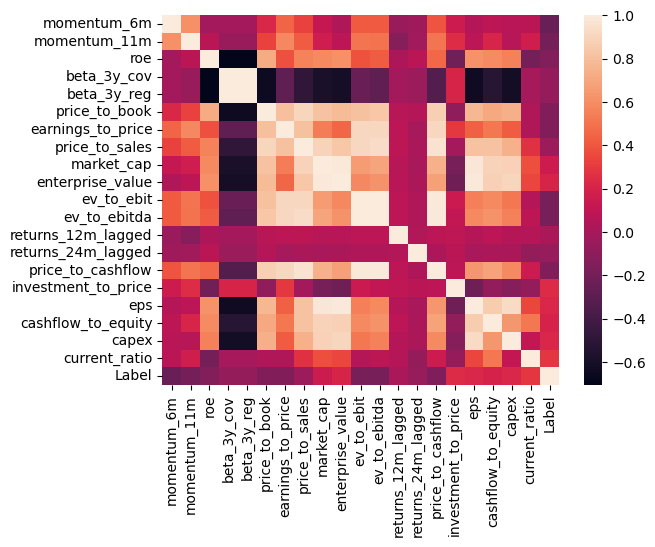

In [38]:
# Análisis de correlaciones entre métricas financieras para HRMS.PA
sns.heatmap(df_final.loc[df_final['Stock']=='HRMS.PA'].iloc[:,2:].corr())


In [39]:
# Checkpoint

# 6. BÚSQUEDA DE HIPERPARÁMETROS MEDIANTE ALGORITMO GENÉTICO

Con el objetivo de mejorar el rendimiento predictivo de los modelos de clasificación, se implementa un procedimiento de optimización de hiperparámetros basado en un Algoritmo Genético (AG). Este tipo de algoritmo resulta especialmente útil cuando el espacio de búsqueda es amplio y no se dispone de una función objetivo diferenciable, como suele ocurrir en problemas de clasificación con árboles de decisión.

### 6.1. DEFINICIÓN DE LA ESTRATEGIA DE BÚSQUEDA

Se sigue el siguiente procedimiento para la implementación del AG:

1) <u>Definición del espacio de búsqueda</u>:  
Se establece un conjunto discreto de valores posibles para los hiperparámetros más relevantes de cada modelo (`DecisionTree`, `RandomForest`, `XGBoost`). Estos valores se definen manualmente y se almacenan en una estructura tipo diccionario (`hyperparameter_space`), que especifica las combinaciones válidas para cada algoritmo.

2) <u>Creación de individuos aleatorios</u>:  
Cada individuo de la población inicial representa una combinación aleatoria de hiperparámetros para un modelo concreto. Esta diversidad inicial permite una exploración efectiva del espacio de búsqueda.

3) <u>Evaluación de individuos</u>:  
Cada individuo se evalúa entrenando un clasificador con sus hiperparámetros y validándolo mediante `TimeSeriesSplit` (validación cruzada temporal con 5 particiones).  
Se utiliza la métrica `Balanced Accuracy Score`, apropiada para problemas de clasificación multiclase con clases desbalanceadas, como es el caso de la variable `Label`. Esta métrica calcula el promedio del `recall` por clase, reduciendo el sesgo hacia clases mayoritarias.

4) <u>Estrategia evolutiva</u>:  

   a) Se selecciona el 50% de los mejores individuos, según su puntuación de evaluación, como base para la siguiente generación.  
   
   b) Se aplica el operador de `crossover`, combinando aleatoriamente los hiperparámetros de dos progenitores para formar nuevos individuos. Se implementa un `two-point crossover`, técnica habitual en algoritmos genéticos clásicos, que permite combinar bloques contiguos de parámetros heredados de los progenitores. Esta configuración sigue el enfoque descrito en Caparrini et al. (2024), donde este tipo de cruce se emplea como mecanismo evolutivo principal.  
   
   c) Se introduce una probabilidad de `mutación aleatoria` sobre uno de los hiperparámetros, escogido al azar, con el fin de diversificar la búsqueda y evitar la convergencia prematura del algoritmo. En coherencia con Caparrini, se fija la probabilidad de mutación en 0.35.

5) <u>Optimización del mejor conjunto de hiperparámetros</u>:  
Después de un número predefinido de generaciones (por defecto, 4), se evalúa la población final y se selecciona el mejor individuo según su puntuación media de validación. Este conjunto se considera óptimo para el modelo correspondiente.

6) <u>Integración posterior</u>:  
Este proceso de optimización se ejecuta en la primera ventana de entrenamiento del backtest. Los hiperparámetros óptimos obtenidos se reutilizan en las siguientes fechas de rebalanceo, replicando el enfoque adoptado en Caparrini et al. (2024). Este mecanismo permite reducir significativamente el coste computacional sin comprometer la calidad del ajuste.

Este enfoque genético proporciona una alternativa eficiente frente a métodos de búsqueda exhaustiva (`grid search`), especialmente cuando se trabaja con modelos no lineales y estructuras de datos temporales como las abordadas en este estudio.


In [41]:
# 1. Definición del espacio de hiperparámetros
# Se especifican los valores posibles para cada hiperparámetro relevante de los modelos a optimizar.
# Esta estructura permite generar combinaciones válidas para RandomForest, XGBoost y DecisionTree.
hyperparameter_space = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],              # Profundidades acotadas y seguras
        'min_samples_split': [5, 10, 20],    # Obliga a tener más ejemplos por división → menos ramas pequeñas
        'min_samples_leaf': [2, 4, 6]        # Previene hojas con 1 solo ejemplo
    },
    'XGBoost': {
        'n_estimators': [100, 150],          # Evita modelos demasiado grandes
        'max_depth': [3, 4, 5],              # Limita capacidad de aprendizaje por árbol individual
        'learning_rate': [0.01, 0.05],       # Baja tasa de aprendizaje para evitar sobreajuste rápido
        'subsample': [0.7, 0.8],             # Estocasticidad para reducir overfitting
        'colsample_bytree': [0.7, 0.8]       # Menor número de columnas → más robustez
    },
    'DecisionTree': {
        'max_depth': [3, 5, 7, 9, 12],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

# 2. Función para crear individuos aleatorios
# Cada individuo representa una combinación de hiperparámetros, generada aleatoriamente desde el espacio definido.
# Esta función se utiliza para inicializar la población del algoritmo genético.
def crear_individuo(modelo):
    return {param: random.choice(values) for param, values in hyperparameter_space[modelo].items()}

# 3. Función de evaluación
# Evalúa la calidad de un individuo (combinación de hiperparámetros) entrenando un clasificador con validación cruzada temporal.
# La métrica utilizada es el Balanced Accuracy Score, adecuada para problemas con clases desbalanceadas.
def evaluar_individuo(X, y, individuo, modelo):
    if modelo == 'RandomForest':
        clf = RandomForestClassifier(**individuo, random_state=42)
    elif modelo == 'XGBoost':
        clf = XGBClassifier(**individuo, use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)
    elif modelo == 'DecisionTree':
        clf = DecisionTreeClassifier(**individuo, random_state=42)
    else:
        raise ValueError("Modelo no reconocido.")

    tscv = TimeSeriesSplit(n_splits=5)  # Se utiliza división temporal, clave para evitar look-ahead bias
    scores = []

    for train_idx, test_idx in tscv.split(X):
        X_train_split, X_test_split = X[train_idx], X[test_idx]
        y_train_split, y_test_split = y[train_idx], y[test_idx]

        # Evita errores si alguna partición no tiene al menos dos clases
        if len(np.unique(y_train_split)) < 2:
            scores.append(0)
            continue

        clf.fit(X_train_split, y_train_split)
        preds = clf.predict(X_test_split)
        score = balanced_accuracy_score(y_test_split, preds)

        scores.append(score)

    return np.mean(scores) if scores else 0

# 4. Función principal del Algoritmo Genético
# Esta función ejecuta el proceso evolutivo completo para encontrar la mejor combinación de hiperparámetros.
# Incluye inicialización de población, evaluación, selección, crossover y mutación.
def genetic_search_hyperparameters(X, y, modelo, n_generaciones=4, poblacion_size=14, prob_mutacion=0.35):
    # Inicialización de población aleatoria
    poblacion = [crear_individuo(modelo) for _ in range(poblacion_size)]

    for generacion in range(n_generaciones):
        print(f"\nGeneración {generacion+1}/{n_generaciones}")

        # Evaluación de toda la población actual
        fitness = [evaluar_individuo(X, y, ind, modelo) for ind in poblacion]

        # Selección de los mejores individuos (top 50%) mediante torneo
        mejores_idx = np.argsort(fitness)[-poblacion_size//2:]
        mejores = [poblacion[i] for i in mejores_idx]

        nuevos = []
        while len(nuevos) < poblacion_size:
            padre, madre = random.sample(mejores, 2)
            # Two-point crossover
            param_keys = list(padre.keys())
            p1, p2 = sorted(random.sample(range(len(param_keys)), 2))
            hijo = {}
            
            for i, param in enumerate(param_keys):
                if p1 <= i <= p2:
                    hijo[param] = madre[param]
                else:
                    hijo[param] = padre[param]

            # Mutación aleatoria en un hiperparámetro del hijo
            if random.random() < prob_mutacion:
                param_mutar = random.choice(list(hijo.keys()))
                hijo[param_mutar] = random.choice(hyperparameter_space[modelo][param_mutar])

            nuevos.append(hijo)

        # Nueva generación sustituye completamente a la anterior
        poblacion = nuevos

    # Evaluación final y retorno del mejor individuo
    fitness_final = [evaluar_individuo(X, y, ind, modelo) for ind in poblacion]
    mejor_idx = np.argmax(fitness_final)
    mejor_individuo = poblacion[mejor_idx]

    print(f"\nMejores hiperparámetros encontrados: {mejor_individuo}")
    return mejor_individuo


In [42]:
# Una alternativa a hacer el AG a mano: utilizar la librería DEAP (como Caparrini et al.)

# 7. IMPLEMENTACIÓN DEL PIPELINE DE INVERSIÓN Y BACKTEST SUPERVISADO

### 7.1. FUNCIÓN DE REBALANCEO CON BÚSQUEDA DE HIPERPARÁMETROS

Se define la función `rebalanceo_backtest`, encargada de ejecutar una estrategia de selección de acciones basada en modelos de clasificación. Esta función incorpora, de forma opcional, la optimización de hiperparámetros mediante un Algoritmo Genético. Su objetivo es simular rebalanceos periódicos de cartera, seleccionando en cada fecha los activos con mayor probabilidad estimada de pertenecer a la clase de mayor rentabilidad futura (`Label = 4`).

El procedimiento se estructura en los siguientes pasos:

1) <u>Preparación de los datos</u>:  
Se ordena el `DataFrame` por `Date` y `Stock`, y se determinan las fechas de rebalanceo aplicando una frecuencia fija definida por el parámetro `rebalance_freq_months`. La primera fecha elegible se calcula garantizando que exista suficiente historial para el entrenamiento (`train_years`) y una separación temporal (`gap_years`) que evite cualquier `look-ahead bias`.

2) <u>Entrenamiento y predicción</u>:  
Para cada fecha de rebalanceo, se construye una ventana de entrenamiento a partir de los años previos definidos por `train_years`, excluyendo el periodo de `gap_years`. En paralelo, se extrae el conjunto de predicción correspondiente a la fecha objetivo. El modelo se entrena sobre los datos históricos y se aplica para predecir la clase de cada activo en esa fecha.

3) <u>Optimización de hiperparámetros</u>:  
Si `usar_genetico=True`, se ejecuta una búsqueda de hiperparámetros mediante Algoritmo Genético únicamente en el primer rebalanceo con datos válidos. El conjunto óptimo obtenido se reutiliza en todos los rebalanceos posteriores, lo que reduce la carga computacional sin comprometer la coherencia metodológica.

4) <u>Evaluación de la precisión del modelo</u>:  
Una vez entrenado el modelo y generadas las predicciones, se calcula la precisión del clasificador en la fecha correspondiente, comparando las clases reales (`Label`) con las predichas. Este valor de `accuracy` se almacena en una lista acumulada (`accuracies`) para su análisis a lo largo del tiempo.

5) <u>Selección de acciones</u>:  
A partir de las probabilidades estimadas (`predict_proba`), se extrae la probabilidad de que cada acción pertenezca a la clase `Label = 4` (retornos superiores al 15%). Se seleccionan las `top_n` acciones con mayor probabilidad de pertenecer a esta clase, consideradas como las más prometedoras para el siguiente periodo de inversión.

6) <u>Extracción dinámica de importancias</u>:  
Cuando el modelo de clasificación utilizado dispone del atributo `feature_importances_` (como en `DecisionTree`, `RandomForest` o `XGBoost`), se extraen las importancias de cada variable justo después del entrenamiento en cada rebalanceo. Estas se almacenan en la lista `importancias_por_rebalanceo`, permitiendo un análisis temporal de la relevancia de cada factor. Esta aproximación se alinea con la metodología de Caparrini et al. (2024), en la que se evalúan las variaciones de importancia por fecha en lugar de utilizar una única estimación agregada.

7) <u>Registro de resultados</u>:  
Para cada fecha de rebalanceo, se guarda la información relevante en una lista denominada `resultados`, que incluye las acciones seleccionadas y sus respectivas probabilidades. Además, se devuelve:

    - El conjunto de hiperparámetros utilizados (`mejores_params`),  
    - La lista de fechas de rebalanceo (`rebalance_dates`),  
    - La secuencia completa de valores de precisión (`accuracies`),  
    - Y la evolución temporal de las importancias de variables (`importancias_por_rebalanceo`), utilizada en secciones posteriores para construir visualizaciones de importancia con barras y errores estándar.

Esta función automatiza todo el ciclo de entrenamiento, evaluación y selección de activos en un entorno simulado. La incorporación de métricas clasificatorias como `accuracy` y la extracción dinámica de importancias proporciona una capa adicional de validación sobre la calidad del modelo, más allá del análisis puramente financiero.


In [44]:
def rebalanceo_backtest(df, rebalance_freq_months=4, train_years=3, gap_years=1, top_n=15, modelo='DecisionTree', usar_genetico=True):
    """
    Realiza un backtest de selección de acciones basado en clasificación supervisada.

    Entrena el modelo en ventanas móviles, optimiza hiperparámetros (opcional) y selecciona las acciones
    con mayor probabilidad de obtener altos retornos (Label = 4) en cada rebalanceo.

    Parámetros:
    - df: DataFrame de características y etiquetas.
    - rebalance_freq_months: Frecuencia de rebalanceo en meses (default=4).
    - train_years: Años de historial para entrenar el modelo (default=3).
    - gap_years: Separación para evitar look-ahead bias (default=1).
    - top_n: Número de acciones a seleccionar (default=15).
    - modelo: Tipo de clasificador ('DecisionTree', 'RandomForest' o 'XGBoost').
    - usar_genetico: Si se optimizan hiperparámetros con algoritmo genético (default=True).

    Retorna:
    - resultados: Lista de acciones seleccionadas en cada rebalanceo.
    - mejores_params: Mejor conjunto de hiperparámetros encontrado (si aplica).
    - rebalance_dates: Fechas en las que se realizaron rebalanceos (útiles para visualización).
    - accuracies: Lista de accuracy por cada rebalanceo, para construir tabla resumen.
    - importancias_por_rebalanceo: Lista con arrays de importancias por cada rebalanceo (si aplica).
    - df_accuracy: DataFrame con las accuracies por modelo y fecha.
    """    
    
    resultados = [] # Almacena las acciones seleccionadas en cada rebalanceo
    mejores_params = None  # guarda los mejores hiperparámetros encontrados
    genetico_realizado = False  # asegura que se haga la búsqueda sólo una vez
    accuracies = []  # guarda la accuracy de cada rebalanceo
    importancias_por_rebalanceo = []  # guarda la importancia de variables en cada rebalanceo
    fechas_rebalanceo = []  # guarda las fechas para el DataFrame final de accuracies

    # Se ordena el dataframe por fecha y por acción
    df = df.sort_values(['Date', 'Stock']).reset_index(drop=True)
    # Se obtienen las fechas únicas y se define cada cuánto hacer rebalanceos
    fechas = df['Date'].sort_values().unique()
    min_meses = 12 * (train_years + gap_years)
    fecha_minima_rebalanceo = fechas[min_meses]
    fechas_filtradas = [f for f in fechas if f >= fecha_minima_rebalanceo]
    rebalance_dates = fechas_filtradas[::rebalance_freq_months]

    for idx, fecha_rebalanceo in enumerate(rebalance_dates):
        train_start = fecha_rebalanceo - pd.DateOffset(years=train_years + gap_years)
        train_end = fecha_rebalanceo - pd.DateOffset(years=gap_years)
        df_train = df[(df['Date'] >= train_start) & (df['Date'] < train_end)]
        df_prediccion = df[df['Date'] == fecha_rebalanceo]
        if df_train.empty or df_prediccion.empty:
            print(f"⚠️ Salto rebalanceo en {fecha_rebalanceo.date()} por falta de datos.")
            continue

        X_train = df_train.drop(columns=['Date', 'Stock', 'Label'])
        y_train = df_train['Label']

        # Ejecución única del algoritmo genético
        if usar_genetico and not genetico_realizado:
            print(f"\n Ejecutando Algoritmo Genético en {fecha_rebalanceo.date()} para {modelo}...")
            mejores_params = genetic_search_hyperparameters(
                X_train.values,
                y_train.values,
                modelo=modelo,
                n_generaciones=4,
                poblacion_size=14,
                prob_mutacion=0.1
            )
            genetico_realizado = True

        # Selección de modelo
        if modelo == 'RandomForest':
            model = RandomForestClassifier(**mejores_params, random_state=42) if mejores_params else RandomForestClassifier(random_state=42)
        elif modelo == 'XGBoost':
            model = XGBClassifier(**mejores_params, use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42) if mejores_params else \
                    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)
        elif modelo == 'DecisionTree':
            model = DecisionTreeClassifier(**mejores_params, random_state=42) if mejores_params else DecisionTreeClassifier(random_state=42)
        else:
            raise ValueError(f"Modelo '{modelo}' no reconocido. Usa 'DecisionTree', 'RandomForest' o 'XGBoost'.")

        model.fit(X_train, y_train)

        # Extraer importancia de variables si el modelo lo permite
        if hasattr(model, "feature_importances_"):
            importancias_por_rebalanceo.append(model.feature_importances_)

        X_pred = df_prediccion.drop(columns=['Date', 'Stock', 'Label'])
        stocks_pred = df_prediccion['Stock'].values
        y_true = df_prediccion['Label'].values
        y_pred = model.predict(X_pred)

        acc = accuracy_score(y_true, y_pred)
        accuracies.append(acc)
        fechas_rebalanceo.append(fecha_rebalanceo)

        # Calcular probabilidades para clase 4
        proba_pred = model.predict_proba(X_pred)
        if 4.0 in model.classes_:
            idx_class_4 = list(model.classes_).index(4.0)
            proba_class_4 = proba_pred[:, idx_class_4]
        else:
            proba_class_4 = np.zeros(len(X_pred))

        seleccion = pd.DataFrame({
            'Stock': stocks_pred,
            'Proba_Class_4': proba_class_4
        }).sort_values(by='Proba_Class_4', ascending=False).head(top_n)

        resultados.append({
            'fecha_rebalanceo': fecha_rebalanceo,
            'acciones_seleccionadas': seleccion['Stock'].tolist(),
            'probas': seleccion['Proba_Class_4'].tolist()
        })

    df_accuracy = pd.DataFrame({
        'Date': fechas_rebalanceo,
        modelo: accuracies
    })

    return resultados, mejores_params, rebalance_dates, accuracies, importancias_por_rebalanceo, df_accuracy


### 7.2. FUNCIÓN DE EJECUCIÓN COMPLETA DEL PIPELINE DE INVERSIÓN

Se define la función `ejecutar_pipeline_modelo`, que encapsula todo el proceso de evaluación de una estrategia de inversión basada en modelos de clasificación. Su objetivo es automatizar la ejecución del backtest y facilitar la comparación entre distintos clasificadores y configuraciones de hiperparámetros.

Se coordinan los distintos componentes desarrollados previamente —rebalanceo, búsqueda genética, cálculo de retornos— en una única llamada, simplificando así la ejecución sistemática de pruebas sobre el rendimiento de la estrategia.

El procedimiento se estructura en los siguientes pasos:

1) <u>Rebalanceo y selección de acciones</u>:  
Se llama a la función `rebalanceo_backtest`, que realiza el entrenamiento, la predicción y la selección de acciones para cada fecha de rebalanceo. Si no se proporcionan hiperparámetros manualmente, se ejecuta una búsqueda genética en el primer rebalanceo con datos válidos, y los hiperparámetros obtenidos se reutilizan en los rebalanceos posteriores.  
Además, se registran la precisión (`accuracy`) del clasificador en cada fecha y las importancias de cada variable explicativa, lo que habilita el análisis temporal de la relevancia de los factores financieros utilizados.

2) <u>Asignación de hiperparámetros</u>:  
Si no se han especificado hiperparámetros al ejecutar la función, se utiliza el conjunto devuelto por `rebalanceo_backtest`. Esto permite automatizar el proceso sin necesidad de definir los parámetros de forma manual.

3) <u>Cálculo de capital acumulado</u>:  
Se aplica la función `calcular_retorno_estrategia`, que emplea la serie de precios (`df_prices_long`) y los resultados de las selecciones para construir la evolución temporal del capital de la cartera. Esta evolución se compara con la de un índice de referencia (`df_benchmark`).

4) <u>Devolución de resultados</u>:  
Se devuelven los siguientes elementos clave para el análisis posterior:

    - La lista de acciones seleccionadas en cada rebalanceo y sus probabilidades (`resultados`),  
    - El conjunto de hiperparámetros utilizados (`mejores_params`),  
    - La evolución del capital acumulado (`df_capital`),  
    - Las fechas de rebalanceo (`rebalance_dates`),  
    - La lista de precisiones clasificatorias (`accuracies`),  
    - Y la evolución de las importancias de variables (`importancias_por_rebalanceo`), útil para estudiar la estabilidad y relevancia de los factores predictivos en el tiempo.

Esta estructura permite comparar el desempeño de diferentes modelos y configuraciones bajo condiciones homogéneas, asegurando coherencia metodológica, eficiencia en la ejecución y capacidad de evaluación cuantitativa del rendimiento clasificatorio.


In [46]:
def ejecutar_pipeline_modelo(df, df_precios, df_benchmark, modelo, usar_genetico=True, mejores_params=None):
    """
    Ejecuta rebalanceo, calcula capital acumulado y devuelve resultados.
    Si se proporcionan hiperparámetros, no se ejecuta el algoritmo genético.
    
    Parámetros:
    - df: DataFrame con características y etiquetas para entrenamiento/predicción.
    - df_precios: DataFrame con la serie histórica de precios en formato largo.
    - df_benchmark: Serie de precios del índice de referencia para comparación.
    - modelo: Clasificador a utilizar ('DecisionTree', 'RandomForest', 'XGBoost').
    - usar_genetico: Flag que indica si se debe aplicar búsqueda genética (default=True).
    - mejores_params: Hiperparámetros ya optimizados, si se desea evitar la búsqueda.

    Retorna:
    - resultados: Lista de acciones seleccionadas en cada rebalanceo.
    - mejores_params: Conjunto de hiperparámetros usados.
    - df_capital: Serie de capital acumulado resultante de la estrategia.
    - rebalance_dates: Fechas en las que se ejecutaron rebalanceos.
    - accuracies: Lista de accuracy por cada rebalanceo.
    - importancias_por_rebalanceo: Lista de arrays de importancias por rebalanceo.
    - df_accuracy: DataFrame con la accuracy por modelo y fecha (para visualización).
    """
    
    print(f"\n Ejecutando pipeline para modelo: {modelo}")
    
    resultados, mejores_params_local, rebalance_dates, accuracies, importancias_por_rebalanceo, df_accuracy = rebalanceo_backtest(
        df,
        modelo=modelo,
        usar_genetico=usar_genetico if mejores_params is None else False
    )

    if mejores_params is None:
        mejores_params = mejores_params_local
    
    df_capital = calcular_retorno_estrategia(df_precios, resultados, df_benchmark)
    
    return resultados, mejores_params, df_capital, rebalance_dates, accuracies, importancias_por_rebalanceo, df_accuracy


### 7.3. FUNCIONES COMPLEMENTARIAS: GUARDADO, SIMULACIÓN Y VISUALIZACIÓN

Se documentan a continuación una serie de funciones auxiliares que completan el flujo del pipeline de backtesting. Estas herramientas se integran con el objetivo de almacenar resultados, simular el rendimiento de las estrategias y generar visualizaciones tanto de la evolución del capital como del calendario de rebalanceos. Su inclusión refuerza la claridad, eficiencia y reproducibilidad del análisis.

##### 7.3.1. Guardado y carga de objetos

1) <u>Guardar objetos</u>:  
Se definen las funciones `guardar_objeto` y `cargar_objeto`, que utilizan el módulo `pickle` para guardar y recuperar objetos de Python desde disco. Estas funciones permiten persistir resultados intermedios como las selecciones (`resultados`) o los hiperparámetros (`mejores_params`), lo que permite:

   - Reducir significativamente el tiempo de ejecución en análisis repetitivos.  
   - Asegurar la trazabilidad y reproducibilidad de los experimentos.  
   - Organizar modularmente los distintos bloques del pipeline.</p>

2) <u>Cargar objetos</u>:  
Permite reanudar una sesión previa de análisis sin necesidad de reentrenar modelos o recalcular métricas, utilizando directamente los resultados almacenados.

##### 7.3.2. Simulación del capital acumulado

3) <u>Cálculo del capital acumulado</u>:  
La función `calcular_retorno_estrategia` simula el crecimiento del capital invertido, utilizando como base las acciones seleccionadas por los modelos en cada fecha de rebalanceo. El procedimiento consiste en:

   - Recorrer cada periodo de rebalanceo,  
   - Obtener los precios de las acciones seleccionadas al inicio y final del periodo,  
   - Calcular el retorno simple individual y su promedio,  
   - Actualizar el capital acumulado mediante la fórmula: $(1 + \text{retorno\_medio})$,  
   - Asumir retorno nulo cuando no se dispone de precios válidos.</p>

   El parámetro `holding_period_months` define la duración del periodo de inversión (por defecto, 4 meses). El resultado es un `DataFrame` indexado por fechas que refleja la evolución temporal del portafolio.

4) <u>Cálculo de métricas de rendimiento</u>:  
La función `calcular_metricas_performance` estima cuatro métricas clave para evaluar una estrategia: retorno total, retorno anualizado, volatilidad anualizada y ratio de Sharpe. Estas métricas se utilizan para comparar cuantitativamente el comportamiento de distintos modelos bajo una base homogénea.

##### 7.3.3. Visualizaciones auxiliares

5) <u>Visualización del calendario de rebalanceo</u>:  
La función `plot_rebalance_dates` genera una representación temporal de las fechas en que se ejecutaron los rebalanceos. Esta visualización permite:

   - Verificar la regularidad de la estrategia,  
   - Confirmar la cobertura temporal completa,  
   - Detectar posibles huecos o anomalías en la secuencia de rebalanceo.</p>

   El gráfico se construye mediante `eventplot`, añadiendo un eje auxiliar agrupado por año para mejorar la legibilidad.

6) <u>Visualización comparativa de estrategias</u>:  
La función `plot_resultados_multi` permite comparar visualmente el capital acumulado generado por los modelos `DecisionTree`, `RandomForest` y `XGBoost`, frente a un benchmark externo (EuroStoxx). La visualización incluye:

   - Trazado de líneas con color distintivo para cada estrategia,  
   - Escalado claro en el eje `x`, con etiquetas trimestrales rotadas,  
   - Leyenda informativa, cuadrículas auxiliares y marcadores verticales de fechas clave,  
   - Opción para guardar automáticamente el gráfico en alta resolución (`guardar=True`).</p>

7) <u>Visualización de la accuracy por modelo</u>:  
La función `plot_accuracies` muestra cómo varía la métrica de `accuracy` para cada modelo en las fechas de rebalanceo. Este gráfico complementa el análisis de capital, permitiendo observar:

   - La estabilidad del rendimiento predictivo en el tiempo,  
   - Diferencias en la calidad de clasificación entre modelos,  
   - La fecha y magnitud del mejor desempeño relativo entre ellos.</p>

   El gráfico incluye líneas verticales en fechas clave (enero, mayo, septiembre), extendidas hasta el clasificador con mayor `accuracy` en cada punto. Esta representación es útil para ilustrar la evolución del ajuste de los modelos, más allá de su impacto directo en el capital.


In [48]:
# 1. Función para guardar objetos
def guardar_objeto(objeto, ruta):
    '''
    Guarda un objeto de Python en la ruta especificada utilizando el módulo pickle.

    Parámetros:
    objeto: Cualquier objeto serializable.
    ruta: Ruta (str) donde guardar el archivo .pkl.
    '''
    with open(ruta, 'wb') as f:
        pickle.dump(objeto, f)

# 2. Función para cargar objetos
def cargar_objeto(ruta):
    '''
    Carga un objeto de Python previamente guardado con pickle.

    Parámetros:
    ruta: Ruta del archivo .pkl a cargar.

    Retorna:
    Objeto deserializado.
    '''
    with open(ruta, 'rb') as f:
        return pickle.load(f)

# 3. Función para calcular capital acumulado para cualquier estrategia
def calcular_retorno_estrategia(df_precios_long, resultados, df_benchmark, holding_period_months=4):
    '''
    Calcula el capital acumulado simulando una estrategia de inversión con rebalanceos periódicos.

    Parámetros:
    df_precios_long: DataFrame con precios (formato largo: ['Stock', 'Date', 'Price']).
    resultados: Lista de dicts con 'fecha_rebalanceo' y 'acciones_seleccionadas'.
    df_benchmark: DataFrame con benchmark de referencia (no se utiliza directamente aquí).
    holding_period_months: Meses entre rebalanceos (default=4).

    Retorna:
    DataFrame con la evolución del capital acumulado por fecha.
    '''
    df_precios_long = df_precios_long.sort_values(['Stock', 'Date']).reset_index(drop=True)
    df_benchmark = df_benchmark.sort_index()
    capital_estrategia = [1] # inicia la simulación con 1 euro (escalabilidad, comparar, etc.)
    fechas_rebalanceo = [r['fecha_rebalanceo'] for r in resultados]

    # Itera por cada fecha de rebalanceo para simular el rendimiento de la cartera
    for i, rebalanceo in enumerate(resultados):
        # Define la fecha actual de rebalanceo
        fecha_inicio = rebalanceo['fecha_rebalanceo']
        # Define la siguiente fecha de rebalanceo
        if i+1 < len(fechas_rebalanceo):
            fecha_fin = fechas_rebalanceo[i+1]
        # Si es el último rebalanceo, simplemente se le suma 4 meses (holding_period_months)
        else:
            fecha_fin = fecha_inicio + pd.DateOffset(months=holding_period_months)
        
        acciones = rebalanceo['acciones_seleccionadas']
        retornos_acciones = []

        # Para cada acción seleccionada...
        for stock in acciones:
            try:
                # Obtiene el precio al inicio y final del periodo
                precio_ini = df_precios_long.query("Date == @fecha_inicio and Stock == @stock")['Price'].iloc[0]
                precio_fin = df_precios_long.query("Date == @fecha_fin and Stock == @stock")['Price'].iloc[0]
                # Calcula el retorno simple ((precio final/precio inicial)-1)
                retorno = (precio_fin / precio_ini) - 1
                retornos_acciones.append(retorno)
            # Si no se encuentra un precio (ejemplo: faltan datos), asume retorno 0
            except IndexError:
                retornos_acciones.append(0)

        # Calcula el retorno promedio de acciones seleccionadas durante periodo rebalanceo
        # Multiplica el capital anterior por (1+retorno) y lo añade a la capital_estrategia
        retorno_medio = np.mean(retornos_acciones) if retornos_acciones else 0
        capital_estrategia.append(capital_estrategia[-1] * (1 + retorno_medio))
   
    # Construye un Dataframe con: fechas de rebalanceo y capital acumulado hasta la fecha  
    df_resultados = pd.DataFrame({
        'Fecha': fechas_rebalanceo + [fechas_rebalanceo[-1] + pd.DateOffset(months=holding_period_months)],
        'Capital': capital_estrategia
    })
    # Establece la fecha como índice
    df_resultados.set_index('Fecha', inplace=True)
    
    return df_resultados

# 4. Función para calcular diversas métricas de interés sobre las estrategias planteadas
def calcular_metricas_performance(df_resultados, nombre_estrategia):
    """
    Calcula el Retorno Total, Retorno Anualizado, Volatilidad Anualizada y Sharpe Ratio de una estrategia.
    
    Parámetros:
    df_resultados: DataFrame con columna 'Capital'
    nombre_estrategia: Nombre de la estrategia (string)

    Retorna:
    Diccionario con métricas clave de rendimiento financiero.
    """
    capital = df_resultados['Capital']
    
    # Calcula los retornos simples a partir del capital acumulado
    retornos = capital.pct_change().dropna()
    
    # Número de rebalanceos por año, asumiendo uno cada 4 meses
    n_rebalanceos_por_año = 12 / 4  # rebalanceo cada 4 meses = 3 veces al año
    
    # Retorno total acumulado durante todo el periodo
    overall_return = (capital.iloc[-1] / capital.iloc[0]) - 1
    
    # Retorno anualizado usando compuesto geométrico
    retorno_anualizado = (1 + overall_return)**(n_rebalanceos_por_año / len(retornos)) - 1
    
    # Volatilidad anualizada de los retornos (riesgo)
    volatilidad_anualizada = retornos.std() * np.sqrt(n_rebalanceos_por_año)
    
    # Sharpe Ratio = retorno ajustado por riesgo
    sharpe_ratio = retorno_anualizado / volatilidad_anualizada if volatilidad_anualizada != 0 else np.nan
    
    # Agrupa todas las métricas en un diccionario
    metricas = {
        'Estrategia': nombre_estrategia,
        'Retorno Total': overall_return,
        'Retorno Anualizado': retorno_anualizado,
        'Volatilidad Anualizada': volatilidad_anualizada,
        'Sharpe Ratio': sharpe_ratio
    }
    
    return metricas

# 5. Función para graficar las fechas de rebalanceo de los modelos de ML
def plot_rebalance_dates(rebalance_dates):
    '''
    Grafica visualmente las fechas de rebalanceo de una estrategia.

    Parámetros:
    rebalance_dates: Lista de fechas (datetime) en las que se realizó rebalanceo.
    '''
    fig, ax = plt.subplots(figsize=(16, 4))

    # Representa cada fecha como un evento en el eje horizontal
    ax.eventplot(rebalance_dates, orientation='horizontal', colors='blue')

    # Etiquetas detalladas para cada rebalanceo
    ax.set_xticks(rebalance_dates)
    ax.set_xticklabels([fecha.strftime('%Y-%m') for fecha in rebalance_dates], rotation=90)
    ax.set_xlabel('Fecha de Rebalanceo', fontsize=12, labelpad=20)

    # Eje superior adicional para mostrar los años
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.xaxis.set_major_locator(mdates.YearLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax2.set_xlabel('Año', fontsize=12, labelpad=10)

    # Personalización visual
    ax.set_title('Fechas de Rebalanceo Realizadas', fontsize=14, pad=30)
    ax.set_yticks([])  # Oculta eje Y
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# 6. Función para graficar varias estrategias juntas
def plot_resultados_multi(df_resultados_dt, df_resultados_rf, df_resultados_xgb,
                          df_benchmark, guardar=False):
    '''
    Genera una visualización comparativa del rendimiento de varias estrategias y un benchmark.

    Parámetros:
    df_resultados_dt, df_resultados_rf, df_resultados_xgb: DataFrames con columna 'Capital'.
    df_benchmark: DataFrame con columna 'Capital_Benchmark'.
    guardar: Booleano. Si True, guarda el gráfico en disco.
    ruta_guardado: Ruta donde guardar la imagen si guardar=True.
    '''

    df_benchmark = df_benchmark.copy()
    fig, ax = plt.subplots(figsize=(16, 9))

    # Dibuja cada estrategia con un color distintivo
    ax.plot(df_resultados_xgb.index, df_resultados_xgb['Capital'], label='XGBoost', color='red', linewidth=2)
    ax.plot(df_resultados_rf.index, df_resultados_rf['Capital'], label='Random Forest', color='darkblue', linewidth=2)
    ax.plot(df_resultados_dt.index, df_resultados_dt['Capital'], label='Decision Tree', color='gold', linewidth=2)
    ax.plot(df_benchmark.index, df_benchmark['Capital_Benchmark'], label='Benchmark Eurostoxx', color='black', linewidth=2)

    # Personalización del gráfico
    ax.set_title('Evolución del Portafolio', fontsize=20)
    ax.set_xlabel('Fecha', fontsize=18)
    ax.set_ylabel('Valor del Portafolio', fontsize=18)
    ax.tick_params(axis='both', labelsize=14)
    ax.legend(loc='upper left', fontsize=20, frameon=False)

    # Filtra fechas clave (trimestrales) para etiquetado del eje X
    fechas = df_benchmark.index
    fechas_filtradas = [f for f in fechas if f.month in [1, 5, 9]]
    if fechas[-1] not in fechas_filtradas:
        fechas_filtradas.append(fechas[-1])
    etiquetas = [f.strftime('%b-%y') for f in fechas_filtradas]
    ax.set_xticks(fechas_filtradas)
    ax.set_xticklabels(etiquetas, rotation=45)

    # Define límites del eje Y para que todo se vea bien
    ymin = min(df_benchmark['Capital_Benchmark'].min(), df_resultados_xgb['Capital'].min(),
               df_resultados_rf['Capital'].min(), df_resultados_dt['Capital'].min()) * 0.95
    ymax = max(df_resultados_xgb['Capital'].max(), df_resultados_rf['Capital'].max(),
               df_resultados_dt['Capital'].max()) * 1.05
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(fechas_filtradas[0], fechas_filtradas[-1])

    # Añade líneas verticales en fechas clave para facilitar comparación
    for f in fechas_filtradas:
        try:
            valores = [
                df_resultados_xgb.at[f, 'Capital'],
                df_resultados_rf.at[f, 'Capital'],
                df_resultados_dt.at[f, 'Capital'],
                df_benchmark.at[f, 'Capital_Benchmark']
            ]
        except KeyError:
            continue
        top4 = sorted(valores)
        nivel_superior = top4[3]
        ax.vlines(x=f, ymin=ymin, ymax=nivel_superior, color='gray', linewidth=1.2, alpha=0.5)

    # Mejora visual del eje Y
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=3))
    ax.tick_params(axis='y', which='minor', length=4, width=1.0, direction='in', color='gray')
    ax.grid(which='minor', axis='y', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.grid(which='major', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    plt.tight_layout()

    # Guarda el gráfico si se indica
    if guardar:
        nombre_archivo = f"resultados_modelos.png"
        plt.savefig(nombre_archivo, dpi=300)
        print(f"📁 Gráfico guardado como: {nombre_archivo}")

    plt.show()

# 7 Función para visualizar la evolución de la precisión por modelo

def plot_accuracies(df_accuracy, guardar=False):
    """
    Visualiza la evolución de la accuracy por clasificador, destacando el mejor modelo en cada fecha clave.
    """
    df_plot = df_accuracy.copy()
    df_plot['Date'] = pd.to_datetime(df_plot['Date'])

    fig, ax = plt.subplots(figsize=(16, 9))

    ax.plot(df_plot['Date'], df_plot['Decision Tree'], label='Decision Tree', color='gold', linewidth=2)
    ax.plot(df_plot['Date'], df_plot['Random Forest'], label='Random Forest', color='darkblue', linewidth=2)
    ax.plot(df_plot['Date'], df_plot['XGBoost'], label='XGBoost', color='red', linewidth=2)

    ax.set_title('Precisión por Clasificador', fontsize=20)
    ax.set_xlabel('Fecha de Rebalanceo', fontsize=18)
    ax.set_ylabel('Precisión', fontsize=18)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', fontsize=16, frameon=False)

    ax.set_xlim(df_plot['Date'].min(), df_plot['Date'].max())

    fechas = df_plot['Date']
    fechas_filtradas = [f for f in fechas if f.month in [1, 5, 9]]
    if fechas.iloc[-1] not in fechas_filtradas:
        fechas_filtradas.append(fechas.iloc[-1])
    etiquetas = [f.strftime('%b-%y') for f in fechas_filtradas]
    ax.set_xticks(fechas_filtradas)
    ax.set_xticklabels(etiquetas, rotation=45)

    for f in fechas_filtradas:
        fila = df_plot[df_plot['Date'] == f][['Decision Tree', 'Random Forest', 'XGBoost']].dropna(axis=1)
        if not fila.empty:
            nivel_superior = fila.iloc[0].max()
            ax.vlines(x=f, ymin=0, ymax=nivel_superior, color='gray', linewidth=1.2, alpha=0.5)

    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=3))
    ax.tick_params(axis='y', which='minor', length=4, width=1.0, direction='in', color='gray')
    ax.grid(which='minor', axis='y', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.grid(which='major', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    plt.tight_layout()

    if guardar:
        nombre_archivo = f"precision_modelos.png"
        plt.savefig(nombre_archivo, dpi=300)
        print(f"📁 Gráfico guardado como: {nombre_archivo}")


    plt.show()



# 8. EJECUCIÓN CONDICIONAL Y ALMACENAMIENTO DE RESULTADOS

### 8.1. EJECUCIÓN CONDICIONAL DE LOS MODELOS DE ML Y GUARDADO DE RESULTADOS

Con el objetivo de evitar ejecuciones redundantes y reducir el tiempo de cómputo, se implementa un mecanismo de almacenamiento en disco que guarda los resultados generados por cada modelo. De esta forma, se reutilizan resultados previamente calculados si ya existen, optimizando la eficiencia del pipeline y facilitando procesos experimentales.

La estructura del procedimiento es la siguiente:

1) <u>Parámetro de control de caché</u>:  
Se define una variable booleana `resetear_resultados` que controla si se deben eliminar los resultados almacenados previamente. Cuando se establece en `True`, se fuerzan nuevas ejecuciones eliminando los archivos existentes; si se mantiene en `False`, se reutilizan directamente los archivos ya almacenados.

2) <u>Definición de carpeta y rutas de resultados</u>:  
Se define una carpeta de caché (`resultados_guardados`) para almacenar los archivos serializados (`.pkl`) de cada modelo (`DecisionTree`, `RandomForest`, `XGBoost`). La carpeta se crea automáticamente con `os.makedirs` si no existe.

3) <u>Eliminación condicional de archivos previos</u>:  
Cuando `resetear_resultados = True`, se eliminan automáticamente los archivos de resultados existentes para asegurar una reejecución limpia. En caso contrario, se conserva la caché sin modificaciones.

4) <u>Ejecución o carga del modelo Decision Tree</u>:  
Se verifica si existe un archivo `.pkl` correspondiente a los resultados previos del modelo `DecisionTree`:
   - Si el archivo está disponible, se cargan los resultados mediante `cargar_objeto`.
   - En caso contrario, se ejecuta el pipeline completo con `ejecutar_pipeline_modelo` y los resultados generados se guardan con `guardar_objeto`.
   - Se almacenan: las acciones seleccionadas, el capital acumulado, los hiperparámetros (`mejores_params_dt`), las fechas de rebalanceo (`rebalance_dates_dt`), la lista de precisiones clasificatorias (`accuracies_dt`) y la evolución temporal de las importancias de variables (`importancias_dt`).</p>

5) <u>Ejecución o carga del modelo Random Forest</u>:  
Se aplica la misma lógica utilizando el archivo `resultados_rf.pkl`. Se registran las selecciones, el capital, los hiperparámetros, las precisiones (`accuracies_rf`) y las importancias de variables (`importancias_rf`).

6) <u>Ejecución o carga del modelo XGBoost</u>:  
Se replica el procedimiento para el modelo `XGBoost`, empleando el archivo `resultados_xgb.pkl` y almacenando las variables correspondientes (`accuracies_xgb`, `importancias_xgb` y demás componentes del pipeline).

Este sistema de almacenamiento presenta las siguientes ventajas:

- <u>Eficiencia computacional</u>: se omite la reejecución completa de modelos, lo que reduce significativamente el tiempo en escenarios computacionalmente intensivos como la búsqueda genética de hiperparámetros.
- <u>Reproducibilidad</u>: se asegura que los resultados permanecen disponibles y consistentes para análisis posteriores y visualizaciones.
- <u>Escalabilidad</u>: el patrón se extiende fácilmente a nuevos clasificadores, configuraciones alternativas o futuros experimentos.

Este mecanismo complementa el pipeline general del proyecto y se alinea con las buenas prácticas de almacenamiento y gestión de resultados en proyectos de aprendizaje automático aplicados al análisis financiero.


In [50]:
# 1. Parámetro para controlar si se eliminan resultados guardados
resetear_resultados = False  # Cambia a True para forzar la reejecución del pipeline

# 2. Archivos de resultados por modelo
carpeta_cache = 'resultados_guardados'
archivos_modelos = {
    'DecisionTree': 'resultados_dt.pkl',
    'RandomForest': 'resultados_rf.pkl',
    'XGBoost': 'resultados_xgb.pkl'
}
os.makedirs(carpeta_cache, exist_ok=True)  # Crear la carpeta si no existe

# 3. Eliminar archivos si se indica
if resetear_resultados:
    print("🔁 Reseteando resultados previos...")
    for archivo in archivos_modelos.values():
        ruta = os.path.join(carpeta_cache, archivo)
        if os.path.exists(ruta):
            os.remove(ruta)
            print(f"🗑️  Archivo eliminado: {archivo}")
        else:
            print(f"ℹ️  Archivo no encontrado (ya estaba eliminado): {archivo}")
else:
    print("✅ Conservando resultados previos (modo caché activado)")

# 4. Modelo Decision Tree
ruta_dt = os.path.join(carpeta_cache, archivos_modelos['DecisionTree'])

if os.path.exists(ruta_dt):
    print("✅ Cargando resultados Decision Tree desde disco...")
    resultados_dt, mejores_params_dt, df_capital_dt, rebalance_dates_dt, accuracies_dt, importancias_dt, df_dt = cargar_objeto(ruta_dt)
else:
    print("Ejecutando modelo Decision Tree...")
    resultados_dt, mejores_params_dt, df_capital_dt, rebalance_dates_dt, accuracies_dt, importancias_dt, df_dt = ejecutar_pipeline_modelo(
        df_final, df_prices_long, df_eurostoxx, modelo='DecisionTree'
    )
    guardar_objeto((resultados_dt, mejores_params_dt, df_capital_dt, rebalance_dates_dt, accuracies_dt, importancias_dt, df_dt), ruta_dt)

# 5. Modelo Random Forest
ruta_rf = os.path.join(carpeta_cache, archivos_modelos['RandomForest'])

if os.path.exists(ruta_rf):
    print("✅ Cargando resultados Random Forest desde disco...")
    resultados_rf, mejores_params_rf, df_capital_rf, rebalance_dates_rf, accuracies_rf, importancias_rf, df_rf = cargar_objeto(ruta_rf)
else:
    print("Ejecutando modelo Random Forest...")
    resultados_rf, mejores_params_rf, df_capital_rf, rebalance_dates_rf, accuracies_rf, importancias_rf, df_rf = ejecutar_pipeline_modelo(
        df_final, df_prices_long, df_eurostoxx, modelo='RandomForest'
    )
    guardar_objeto((resultados_rf, mejores_params_rf, df_capital_rf, rebalance_dates_rf, accuracies_rf, importancias_rf, df_rf), ruta_rf)

# 6. Modelo XGBoost
ruta_xgb = os.path.join(carpeta_cache, archivos_modelos['XGBoost'])

if os.path.exists(ruta_xgb):
    print("✅ Cargando resultados XGBoost desde disco...")
    resultados_xgb, mejores_params_xgb, df_capital_xgb, rebalance_dates_xgb, accuracies_xgb, importancias_xgb, df_xgb = cargar_objeto(ruta_xgb)
else:
    print("Ejecutando modelo XGBoost...")
    resultados_xgb, mejores_params_xgb, df_capital_xgb, rebalance_dates_xgb, accuracies_xgb, importancias_xgb, df_xgb = ejecutar_pipeline_modelo(
        df_final, df_prices_long, df_eurostoxx, modelo='XGBoost'
    )
    guardar_objeto((resultados_xgb, mejores_params_xgb, df_capital_xgb, rebalance_dates_xgb, accuracies_xgb, importancias_xgb, df_xgb), ruta_xgb)


✅ Conservando resultados previos (modo caché activado)
✅ Cargando resultados Decision Tree desde disco...
✅ Cargando resultados Random Forest desde disco...
✅ Cargando resultados XGBoost desde disco...


In [51]:
# Checkpoint

### 8.2. VISUALIZACIÓN DE LOS HIPERPARÁMETROS ENCONTRADOS

En este apartado se recopilan y presentan de forma estructurada los mejores hiperparámetros encontrados para cada uno de los tres modelos base utilizados: `DecisionTree`, `RandomForest` y `XGBoost`. Estos hiperparámetros se obtienen durante la ejecución del proceso de rebalanceo, específicamente en el primer ciclo de entrenamiento con búsqueda genética activada.

Se sigue el siguiente procedimiento:

1) <u>Inicialización del diccionario de resultados</u>:  
Se crea un diccionario denominado `hiperparametros_encontrados`, en el cual se almacenan los conjuntos óptimos de hiperparámetros devueltos por el pipeline correspondiente a cada modelo. Esta estructura centraliza los resultados para su reutilización o análisis posterior.

2) <u>Creación del resumen tabulado</u>:  
A partir del diccionario anterior, se construye un `DataFrame` llamado `df_hiperparametros`, donde cada fila representa un modelo y cada columna un hiperparámetro optimizado. Este formato facilita la comparación técnica entre algoritmos.

3) <u>Visualización de resultados</u>:  
El `DataFrame` se presenta en formato HTML para facilitar su interpretación en entornos interactivos. La tabla muestra explícitamente los valores óptimos seleccionados para cada clasificador durante el proceso de búsqueda genética.

Esta representación permite documentar y contrastar las configuraciones óptimas detectadas, garantizando la trazabilidad de los resultados y facilitando su replicación en futuras ejecuciones del pipeline.


In [53]:
# 1. Inicializar diccionario con los mejores hiperparámetros encontrados por cada modelo
hiperparametros_encontrados = {
    'DecisionTree': mejores_params_dt,
    'RandomForest': mejores_params_rf,
    'XGBoost': mejores_params_xgb
}

# 2. Construir un DataFrame tabulado a partir del diccionario
df_hiperparametros = pd.DataFrame([
    {'Modelo': modelo, **params} for modelo, params in hiperparametros_encontrados.items()
])

# 3. Mostrar el resumen visualmente en formato HTML
display(HTML(df_hiperparametros.to_html(index=False)))


Modelo,max_depth,min_samples_split,min_samples_leaf,n_estimators,learning_rate,subsample,colsample_bytree
DecisionTree,9,5.0,2.0,NaN,NaN,NaN,NaN
RandomForest,7,20.0,4.0,200.0,NaN,NaN,NaN
XGBoost,5,NaN,NaN,100.0,0.05,0.8,0.7


### 8.3. VISUALIZACIÓN DEL CALENDARIO DE REBALANCEO

Una vez ejecutado el backtest completo y generadas las fechas efectivas de rebalanceo, se muestra un resumen del periodo cubierto y la cantidad total de rebalanceos realizados. Esta información permite verificar que la estrategia se aplica de forma continua y coherente a lo largo del horizonte temporal definido.

A continuación, se utiliza la función `plot_rebalance_dates` para representar gráficamente la distribución temporal de los rebalanceos. Esta visualización facilita la inspección de la cadencia de ejecución y permite detectar posibles irregularidades o interrupciones en el calendario previsto.

Esta representación se emplea durante la fase de validación del pipeline y se incorpora también como documentación visual de la estructura temporal de la estrategia implementada.


Se han realizado un total de 44 rebalanceos entre 2005-01 y 2019-05.




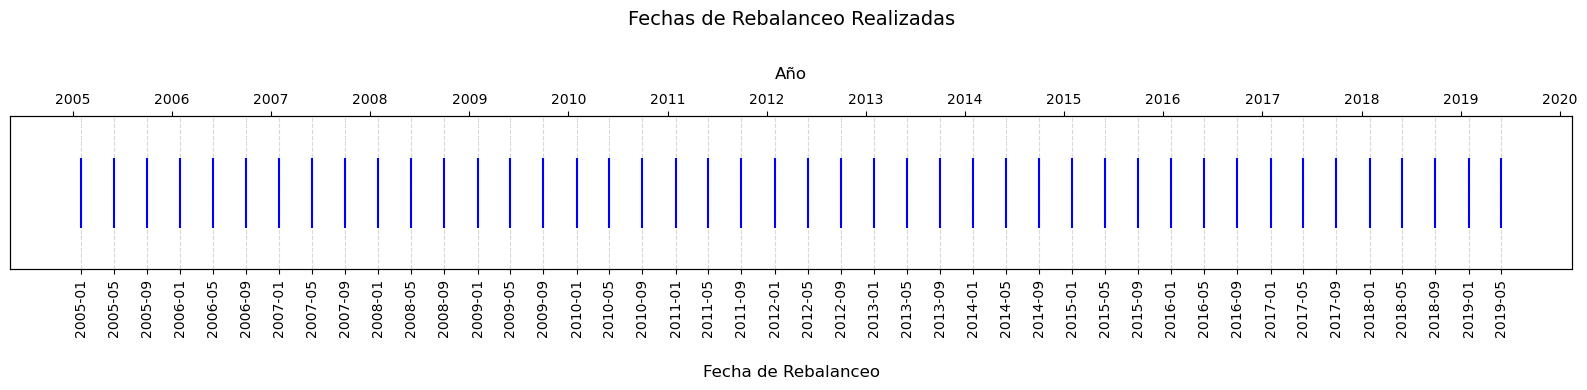

In [55]:
# 1. Mostrar mensaje con número total de rebalanceos y el rango temporal cubierto
print("Se han realizado un total de {} rebalanceos entre {}.".format(
    len(rebalance_dates_dt),
    rebalance_dates_dt[0].strftime('%Y-%m') + " y " + rebalance_dates_dt[-1].strftime('%Y-%m')
))

# 2. Generar gráfico con la distribución temporal de las fechas de rebalanceo
print("\n")  # Separador visual
plot_rebalance_dates(rebalance_dates_dt)


### 8.4. VISUALIZACIÓN DE LA PRECISIÓN PREDICTIVA DE LOS MODELOS

Además del análisis sobre el capital acumulado, resulta fundamental evaluar el rendimiento clasificatorio de los modelos a lo largo del tiempo. En esta sección se presenta una visualización comparativa de la métrica de `accuracy` obtenida en cada fecha de rebalanceo, calculada en el conjunto de predicción.

Este enfoque permite detectar la evolución temporal del poder predictivo de los clasificadores y comparar sus comportamientos relativos en distintos contextos de mercado.

Se sigue el siguiente procedimiento:

1) <u>Consolidación de resultados</u>:  
Se construye un `DataFrame` unificado a partir de los resultados individuales generados por cada modelo (`df_dt`, `df_rf`, `df_xgb`). Para mejorar la legibilidad del gráfico, se renombran las columnas con los nombres completos de los clasificadores.

2) <u>Generación de gráfico</u>:  
Se utiliza la función `plot_accuracies(df_all)`, que representa la evolución de la `accuracy` en cada fecha de rebalanceo para los tres modelos. Esta visualización incluye:

   - Líneas de color diferenciadas por clasificador (`Decision Tree`, `Random Forest`, `XGBoost`),  
   - Fechas destacadas en el eje temporal (enero, mayo, septiembre),  
   - Líneas verticales que conectan con el modelo líder en cada periodo clave,  
   - Escalado claro, leyenda superior y estilo visual uniforme.

Este gráfico actúa como complemento interpretativo del rendimiento de los modelos, permitiendo observar posibles mejoras, deterioros o variaciones en la capacidad de predicción conforme cambia el entorno del mercado.


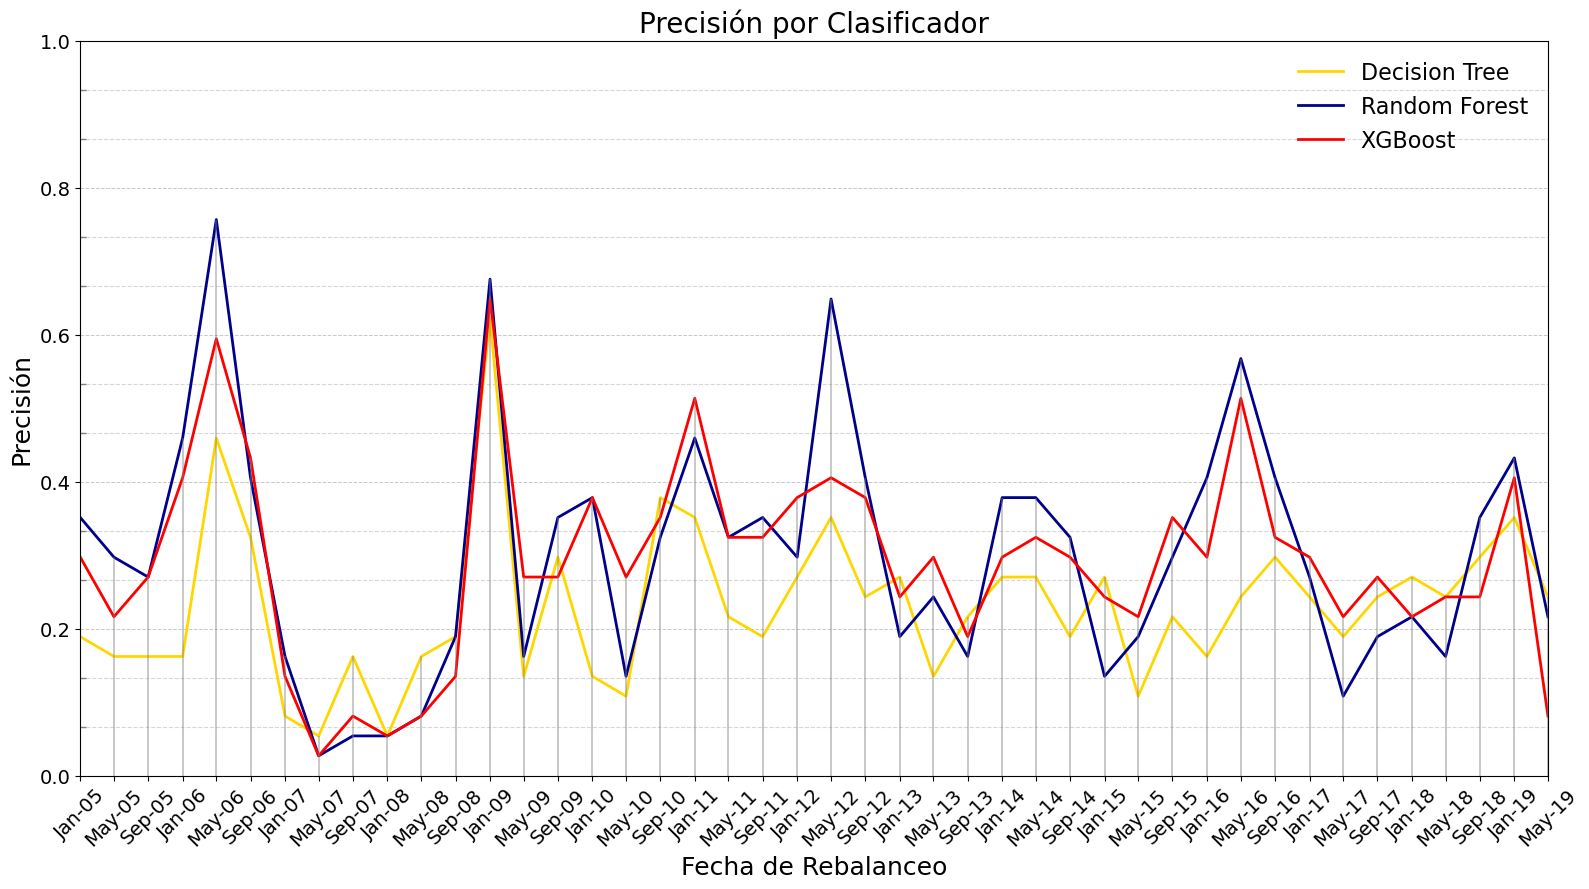

In [57]:
# 1. Consoliación de resultados
df_all = df_dt.copy()
df_all.rename(columns={'DecisionTree': 'Decision Tree'}, inplace=True)
df_all['Random Forest'] = df_rf['RandomForest']
df_all['XGBoost'] = df_xgb['XGBoost']

# 2. Generación del gráfico
plot_accuracies(df_all, guardar=False) # Cambiar a True para guardar el gráfico

### 8.5. EVALUACIÓN COMPARATIVA MEDIANTE PRECISIÓN DE LOS CLASIFICADORES

Se analiza el rendimiento predictivo de los modelos utilizados desde una perspectiva estrictamente clasificatoria. A diferencia del análisis financiero basado en métricas de rentabilidad y riesgo, este apartado evalúa la precisión de los clasificadores en función de su capacidad para etiquetar correctamente las observaciones del conjunto de test en cada fecha de rebalanceo.

Se sigue el siguiente procedimiento:

1) <u>Cálculo de precisión por rebalanceo</u>:  
Durante la ejecución de la función `rebalanceo_backtest`, se almacena la precisión obtenida por cada clasificador al predecir sobre el conjunto de validación correspondiente a cada rebalanceo mensual. Este proceso se aplica a los tres modelos considerados (`DecisionTree`, `RandomForest`, `XGBoost`), generando una lista de 44 valores de precisión para cada uno.

2) <u>Agregación estadística</u>:  
A partir de las listas completas de precisión, se calcula la media aritmética y la desviación estándar. La media resume el rendimiento clasificatorio promedio de cada modelo, mientras que la desviación refleja la variabilidad temporal de ese rendimiento.

3) <u>Construcción de tabla resumen</u>:  
Los resultados se agrupan en un único `DataFrame` (`df_accuracy`), que presenta los valores medios y desviaciones estándar de manera estructurada, lo que facilita la comparación entre modelos. Los datos se redondean a tres decimales para optimizar su legibilidad en notebooks interactivos.

Este análisis permite evaluar cuantitativamente la calidad predictiva de los modelos sin incorporar aún consideraciones económicas. Se trata de una validación previa útil para fundamentar su aplicabilidad en contextos de selección de activos o diseño de estrategias basadas en inteligencia artificial.


In [59]:
# 1. Crear tabla con precisión media y desviación por modelo
df_accuracy = pd.DataFrame({
    'Modelo': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Precisión Media': [
        np.mean(accuracies_dt),
        np.mean(accuracies_rf),
        np.mean(accuracies_xgb)
    ],
    'Desviación Estándar': [
        np.std(accuracies_dt),
        np.std(accuracies_rf),
        np.std(accuracies_xgb)
    ]
}).round(3)

# 2. Mostrar la tabla formateada
print("\nTabla de precisión de los clasificadores (Classifier Accuracy):")
print("\n")  # Separador visual
display(HTML(df_accuracy.to_html(index=False)))



Tabla de precisión de los clasificadores (Classifier Accuracy):




Modelo,Precisión Media,Desviación Estándar
Decision Tree,0.232,0.105
Random Forest,0.301,0.163
XGBoost,0.291,0.132


### 8.6. EVALUACIÓN COMPARATIVA MEDIANTE MÉTRICAS PERFORMANCE

En este apartado se lleva a cabo una evaluación cuantitativa del rendimiento de cada estrategia de inversión basada en modelos de clasificación. Para ello, se utilizan métricas financieras estándar que permiten analizar y comparar los resultados de forma objetiva y replicable.

Se sigue el siguiente procedimiento:

1) <u>Control de ejecución y reutilización de resultados</u>:  
Se define un parámetro de control `recalcular_metricas_finales`, que determina si debe ejecutarse nuevamente el pipeline completo para los modelos (`DecisionTree`, `RandomForest`, `XGBoost`) o si se reutilizan los resultados previamente almacenados en disco.  
Este mecanismo mejora la eficiencia computacional y garantiza la reproducibilidad del análisis.

2) <u>Cálculo de los retornos de capital</u>:  
Cuando `recalcular_metricas_finales=True`, se ejecuta nuevamente el pipeline de rebalanceo para cada modelo, utilizando los mejores hiperparámetros previamente identificados (`mejores_params_*`) y desactivando la búsqueda genética (`usar_genetico=False`).  
Se genera así una serie limpia y coherente de capital acumulado (`df_capital_*`) para cada estrategia, que se emplea como base en el análisis de performance.  
Los resultados se almacenan automáticamente para su uso en futuras sesiones sin necesidad de recomputación.

3) <u>Cálculo de métricas de performance</u>:  
A partir de los DataFrames de capital acumulado, se calculan las métricas de evaluación financiera mediante la función `calcular_metricas_performance`, que estima:

   - Retorno total (%)  
   - Retorno anualizado (%)  
   - Volatilidad anualizada (%)  
   - Ratio de Sharpe</p>

    Estas métricas permiten evaluar tanto el rendimiento absoluto como el perfil riesgo-retorno de cada estrategia.

4) <u>Unificación de resultados</u>:  
Las métricas obtenidas se agrupan en un único `DataFrame` (`df_metricas`), que presenta los resultados de forma estructurada y comparable.  
Los valores se redondean y se expresan en porcentaje cuando corresponde. La tabla final se muestra en formato HTML sin índices, facilitando su interpretación en entornos interactivos.

Este resumen proporciona una comparación objetiva entre las distintas estrategias basadas en clasificación supervisada, sirviendo como base para la formulación de conclusiones y justificación de decisiones en contextos reales de selección de activos.


In [61]:
# 1. Parámetro de control para forzar recálculo de métricas finales
recalcular_metricas_finales = False  # Cambia a True si quieres rehacer todo desde cero

# Ruta de almacenamiento de resultados finales
carpeta_cache = 'resultados_guardados'
os.makedirs(carpeta_cache, exist_ok=True)
ruta_resultados_finales = os.path.join(carpeta_cache, 'resultados_finales.pkl')

# Cargar o calcular los capitales acumulados con hiperparámetros optimizados
if not os.path.exists(ruta_resultados_finales) or recalcular_metricas_finales:
    print("🚀 Ejecutando pipeline final para los 3 modelos con hiperparámetros optimizados...")

    resultados_dt, _, df_capital_dt, _, _, _, _ = ejecutar_pipeline_modelo(
        df_final, df_prices_long, df_eurostoxx,
        modelo='DecisionTree',
        usar_genetico=False,
        mejores_params=mejores_params_dt
    )

    resultados_rf, _, df_capital_rf, _, _, _, _ = ejecutar_pipeline_modelo(
        df_final, df_prices_long, df_eurostoxx,
        modelo='RandomForest',
        usar_genetico=False,
        mejores_params=mejores_params_rf
    )

    resultados_xgb, _, df_capital_xgb, _, _, _, _ = ejecutar_pipeline_modelo(
        df_final, df_prices_long, df_eurostoxx,
        modelo='XGBoost',
        usar_genetico=False,
        mejores_params=mejores_params_xgb
    )

    guardar_objeto((df_capital_dt, df_capital_rf, df_capital_xgb), ruta_resultados_finales)

else:
    print("✅ Cargando resultados finales desde disco...")
    df_capital_dt, df_capital_rf, df_capital_xgb = cargar_objeto(ruta_resultados_finales)

# 2. Calcular métricas de performance para cada estrategia
metricas_dt = calcular_metricas_performance(df_capital_dt, 'Decision Tree')
metricas_rf = calcular_metricas_performance(df_capital_rf, 'Random Forest')
metricas_xgb = calcular_metricas_performance(df_capital_xgb, 'XGBoost')

# 3. Construir DataFrame de métricas finales
df_metricas = pd.DataFrame([
    {
        'Cartera': m['Estrategia'],
        'Retorno Total (%)': m['Retorno Total'] * 100,
        'Retorno Anualizado (%)': m['Retorno Anualizado'] * 100,
        'Volatilidad Anualizada (%)': m['Volatilidad Anualizada'] * 100,
        'Ratio de Sharpe': m['Sharpe Ratio']
    }
    for m in [metricas_dt, metricas_rf, metricas_xgb]
])

df_metricas = df_metricas.round(2)

# Visualización clara
print("\nTabla de rendimiento de las carteras (Portfolio Returns):")
print("\n")  # Separador visual
display(HTML(df_metricas.to_html(index=False)))


✅ Cargando resultados finales desde disco...

Tabla de rendimiento de las carteras (Portfolio Returns):




Cartera,Retorno Total (%),Retorno Anualizado (%),Volatilidad Anualizada (%),Ratio de Sharpe
Decision Tree,378.97,11.27,19.03,0.59
Random Forest,168.26,6.96,20.56,0.34
XGBoost,189.59,7.52,20.46,0.37


### 8.7. EVALUACIÓN DEL RENDIMIENTO DE LOS MODELOS Y VISUALIZACIÓN COMPARATIVA

En esta etapa final se consolida la información generada por cada modelo y se presenta una visualización conjunta de la evolución del capital acumulado. Esta representación permite evaluar comparativamente el rendimiento de las distintas estrategias frente a un benchmark de referencia (Eurostoxx).

Se siguen los siguientes pasos:

1) <u>Cálculo de retornos acumulados por modelo</u>:  
Se aplica la función `calcular_retorno_estrategia` para simular la evolución del capital invertido siguiendo las acciones seleccionadas en cada rebalanceo. Este procedimiento se ejecuta para los tres modelos considerados (`DecisionTree`, `RandomForest`, `XGBoost`), utilizando la serie de precios `df_prices_long` y los resultados almacenados en `resultados_*`.

2) <u>Ajuste temporal del benchmark</u>:  
Para garantizar una comparación homogénea, se identifican las fechas mínima y máxima en las que los modelos generan capital, y se recorta el `DataFrame` `df_eurostoxx` a ese mismo rango temporal.

3) <u>Reescalado del benchmark</u>:  
El índice Eurostoxx se normaliza iniciando en valor 1, generando la columna `Capital_Benchmark`, que permite comparar directamente su rendimiento acumulado con el de los modelos.

4) <u>Visualización final comparativa</u>:  
Se ejecuta la función `plot_resultados_multi`, que genera un gráfico conjunto con la evolución del capital acumulado por cada modelo y el benchmark. La visualización incorpora:

    - Trazado individual para cada estrategia,  
    - Estilo claro y coherente (colores diferenciados, leyenda, fechas clave),  
    - Rejilla auxiliar y escalado adecuado en los ejes.

Mediante esta representación se visualizan las diferencias de desempeño entre modelos, lo que facilita el análisis comparativo de consistencia, crecimiento relativo y comportamiento frente al mercado. Esta herramienta puede emplearse como soporte visual para argumentar la elección de un modelo en contextos prácticos de inversión o investigación.


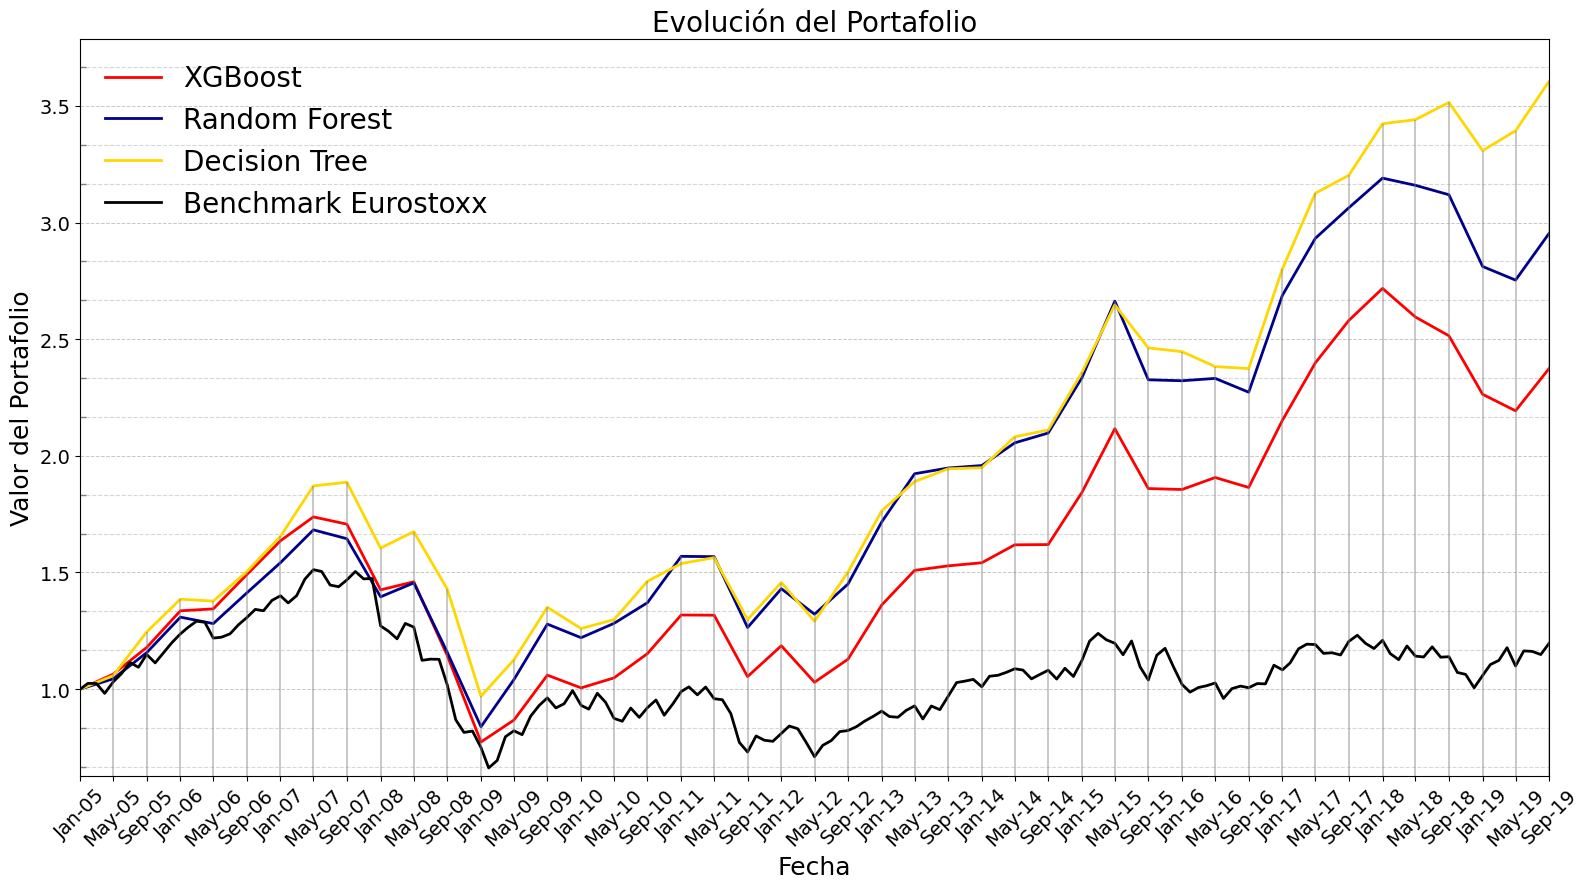

In [63]:
# 1. Calcular retornos acumulados por modelo
df_capital_dt = calcular_retorno_estrategia(df_prices_long, resultados_dt, df_eurostoxx)
df_capital_rf = calcular_retorno_estrategia(df_prices_long, resultados_rf, df_eurostoxx)
df_capital_xgb = calcular_retorno_estrategia(df_prices_long, resultados_xgb, df_eurostoxx)

# 2. Ajuste temporal del benchmark
fecha_min = min(
    df_capital_dt.index.min(),
    df_capital_rf.index.min(),
    df_capital_xgb.index.min()
)
fecha_max = max(
    df_capital_dt.index.max(),
    df_capital_rf.index.max(),
    df_capital_xgb.index.max()
)

# 3. Reescalado del benchmark
df_eurostoxx = df_eurostoxx[(df_eurostoxx.index >= fecha_min) & (df_eurostoxx.index <= fecha_max)].copy()
df_eurostoxx['Capital_Benchmark'] = df_eurostoxx['Price Close'] / df_eurostoxx['Price Close'].iloc[0]

# 4. Visualización final comparativa
plot_resultados_multi(
    df_capital_dt, df_capital_rf, df_capital_xgb, df_eurostoxx,
        guardar=False  # Cambiar a True si se desea guardar el gráfico
)


In [64]:
# Checkpoint

# 9. ANÁLISIS DE IMPORTANCIA DE VARIABLES

### 9.1. DEFINICIÓN DE LAS FUNCIONES DE ANÁLISIS

Se realiza un análisis dinámico de la importancia de variables (`features`) para cada uno de los modelos utilizados (`DecisionTree`, `RandomForest`, `XGBoost`), con el objetivo de interpretar mejor los factores que impulsan la clasificación de las acciones. A diferencia del enfoque estático —basado en un único entrenamiento sobre todo el histórico—, en esta versión se calcula la importancia de cada variable en cada rebalanceo. Esto permite capturar la evolución temporal de su relevancia en la toma de decisiones del modelo.

Se sigue el siguiente procedimiento:

1) <u>Consolidación y análisis estadístico</u>:  
Durante el proceso de backtesting, se registran las importancias de variables en cada rebalanceo. La función `consolidar_importancias` permite, a partir de esta colección, calcular para cada variable su importancia media y la desviación estándar asociada.  
Este análisis permite distinguir entre variables consistentemente relevantes y aquellas con un impacto más volátil o sensible al contexto de mercado.

2) <u>Visualización con barras de error</u>:  
A partir de los resultados anteriores, se genera un gráfico de barras horizontales en el que las variables aparecen ordenadas según su importancia media.  
Las barras de error representan la desviación estándar, aportando una indicación visual de la estabilidad temporal del peso asignado a cada factor por el modelo.  
La función `plot_importancias_con_error` incluye un parámetro opcional `guardar`, que permite exportar automáticamente el gráfico como archivo `.png` con nombre personalizado.

3) <u>Seguimiento temporal individual por variable</u>:  
Para un análisis detallado por variable, se utiliza la función `plot_importancia_por_feature`, que genera una cuadrícula de subgráficos —uno por variable— mostrando su evolución temporal a lo largo del periodo de backtest.  
Este enfoque permite identificar patrones de comportamiento, picos de influencia o caídas sostenidas en la relevancia de cada factor.  
Se asignan colores específicos y persistentes a cada variable, coincidiendo con los utilizados en Caparrini et al. (2024), con el fin de mantener la coherencia visual en las representaciones gráficas. También se habilita la opción de exportación mediante el argumento `guardar`.

Este análisis proporciona una visión cuantitativa e interpretativa sobre los factores más influyentes en los modelos de clasificación utilizados. Además, permite comparar la estabilidad y relevancia relativa de las variables entre modelos, aportando valor adicional en la validación técnica y económica de la estrategia.


In [66]:
def consolidar_importancias(importancias_lista, nombres_features):
    """
    Calcula la media y desviación estándar de la importancia de cada feature
    a lo largo de los rebalanceos.

    Parámetros:
    - importancias_lista: lista de arrays con importancias por rebalanceo.
    - nombres_features: lista con los nombres de las variables (ordenadas como en el modelo).

    Retorna:
    - DataFrame con columnas ['Feature', 'Mean Importance', 'Std Importance']
    """
    importancias_array = np.vstack(importancias_lista)
    medias = importancias_array.mean(axis=0)
    desvios = importancias_array.std(axis=0)

    return pd.DataFrame({
        'Feature': nombres_features,
        'Mean Importance': medias,
        'Std Importance': desvios
    }).sort_values(by='Mean Importance', ascending=False)


def plot_importancias_con_error(df_importancia, modelo, guardar=False):
    """
    Genera un gráfico de barras horizontales con barras de error.

    Parámetros:
    - df_importancia: DataFrame con columnas 'Feature', 'Mean Importance', 'Std Importance'
    - modelo: nombre del modelo para usar como título
    - guardar: si True, guarda el gráfico como imagen PNG con el nombre del modelo
    """

    plt.figure(figsize=(12, 6))
    plt.barh(df_importancia['Feature'], df_importancia['Mean Importance'],
             xerr=df_importancia['Std Importance'], alpha=0.75, capsize=5, color='steelblue')
    plt.xlabel("Importancia Promedio")
    plt.title(f"Importancia de Variables - {modelo}")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()

    if guardar:
        nombre_archivo = f"importancias_{modelo.lower().replace(' ', '_')}.png"
        plt.savefig(nombre_archivo, dpi=300)
        print(f"📁 Gráfico guardado como: {nombre_archivo}")

    plt.show()

def plot_importancia_por_feature(importancias, fechas, features, nombre_modelo, guardar=False):
    """
    Crea una grilla de subgráficos que muestra cómo cambia la importancia de cada feature a lo largo del tiempo.

    Parámetros:
    - importancias: lista de arrays con importancias por rebalanceo.
    - fechas: lista de fechas de rebalanceo.
    - features: lista con los nombres de las variables.
    - nombre_modelo: nombre del modelo (para el título).
    - guardar: si True, guarda la imagen como PNG.
    """
    df = pd.DataFrame(importancias, columns=features, index=pd.to_datetime(fechas))

    n_cols = 4 # Número de gráficos por fila
    n_rows = int(np.ceil(len(features) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12), sharey=True)
    axes = axes.flatten()

    # Diccionario de colores personalizados (usado solo aquí)
    colores_personalizados = {
    'momentum_6m': '#6a5acd',             # índigo
    'momentum_11m': '#eb6818',            # marrón
    'roe': '#00bf63',                     # verde
    'beta_3y_cov': '#9c75de',             # morado
    'beta_3y_reg': '#ff914d',             # naranja
    'price_to_book': '#38b6ff',           # celeste
    'earnings_to_price': '#ff8585',       # rojo
    'price_to_sales': '#89de65',          # lima
    'market_cap': '#ffacec',              # rosa
    'enterprise_value': '#ffbd59',        # amarillo
    'ev_to_ebit': '#6a5acd',              # índigo
    'ev_to_ebitda': '#eb6818',            # marrón
    'returns_12m_lagged': '#00bf63',      # verde
    'returns_24m_lagged': '#9c75de',      # morado
    'price_to_cashflow': '#ff914d',       # naranja
    'investment_to_price': '#38b6ff',     # celeste
    'eps': '#ff8585',                     # rojo
    'current_ratio': '#89de65',           # lima
    'cashflow_to_equity': '#ffacec',      # rosa
    'capex': '#ffbd59'                    # amarillo
}

    for i, feature in enumerate(features):
        ax = axes[i]
        ax.set_facecolor('#eaf2f8')  # Azul claro de fondo
        color = colores_personalizados.get(feature, 'gray')
        ax.plot(df[feature], df.index, color=color, lw=2.5)
        ax.set_title(feature, fontsize=15)
        ax.invert_yaxis()
        ax.set_yticks(pd.to_datetime(['2005', '2010', '2015', '2020'])) # Opcional
        ax.set_yticklabels(['2005', '2010', '2015', '2020']) # Opcional
        ax.tick_params(axis='both', labelsize=14, width=2, length=8)
        ax.grid(True, linestyle='-', color='white', alpha=0.8, linewidth=3)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"{nombre_modelo} - Evolución de la Importancia de Factores", fontsize=18, fontweight='normal')
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    if guardar:
        nombre_archivo = f"importancias_grid_{nombre_modelo.lower().replace(' ', '_')}.png"
        fig.savefig(nombre_archivo, dpi=300)
        print(f"📁 Gráfico guardado como: {nombre_archivo}")

    plt.show()


### 9.2. ANÁLISIS AGREGADO DE IMPORTANCIA POR MODELO

Una vez definidas las funciones de análisis y completado el proceso de backtesting, se consolida y representa la importancia de variables para cada uno de los modelos evaluados.

Se sigue el siguiente procedimiento:

1) <u>Agregación de importancias por modelo</u>:  
Se aplica la función `consolidar_importancias` para calcular, a partir de las listas generadas en cada rebalanceo, la media y la desviación estándar de cada variable.  
Este proceso se ejecuta de forma independiente para `DecisionTree`, `RandomForest` y `XGBoost`, utilizando un conjunto común de variables (`features_finales`) para asegurar una comparación estructural coherente.

2) <u>Visualización comparativa</u>:  
Se genera un gráfico de barras para cada modelo mediante la función `plot_importancias_con_error`.  
Cada visualización representa las variables ordenadas por su importancia media, incluyendo barras de error que reflejan la desviación estándar correspondiente. Esto permite evaluar tanto la influencia relativa de cada factor como la estabilidad de su relevancia a lo largo del tiempo.

Este análisis facilita la identificación de los factores más determinantes en cada modelo y permite contrastar la consistencia temporal de sus contribuciones, lo cual resulta clave para la interpretación y validación técnica del enfoque clasificatorio adoptado.


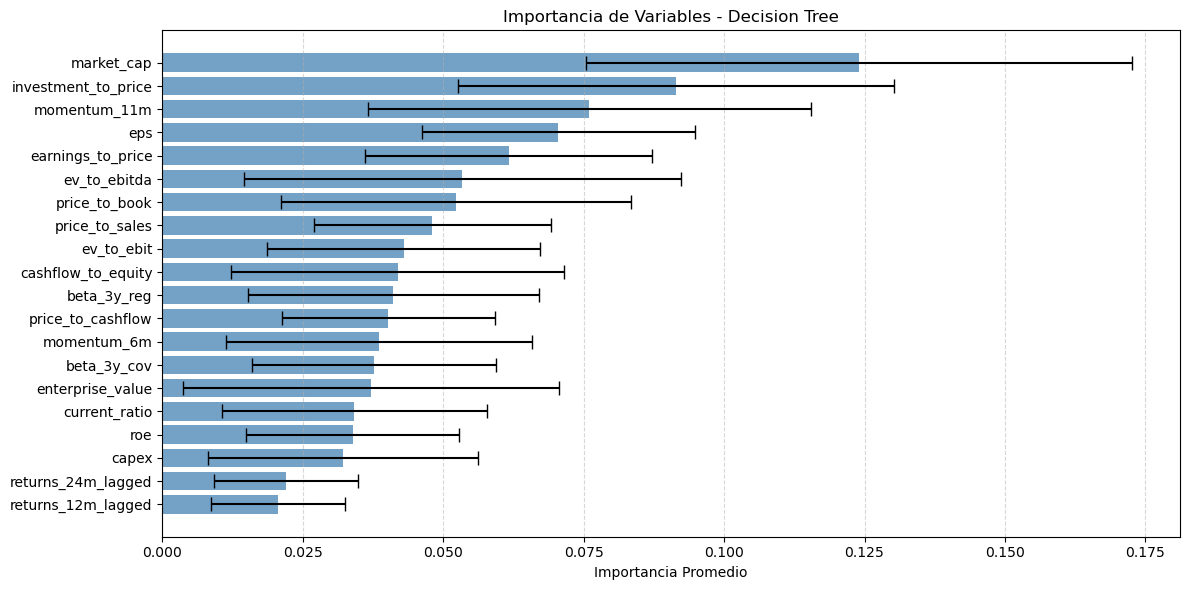

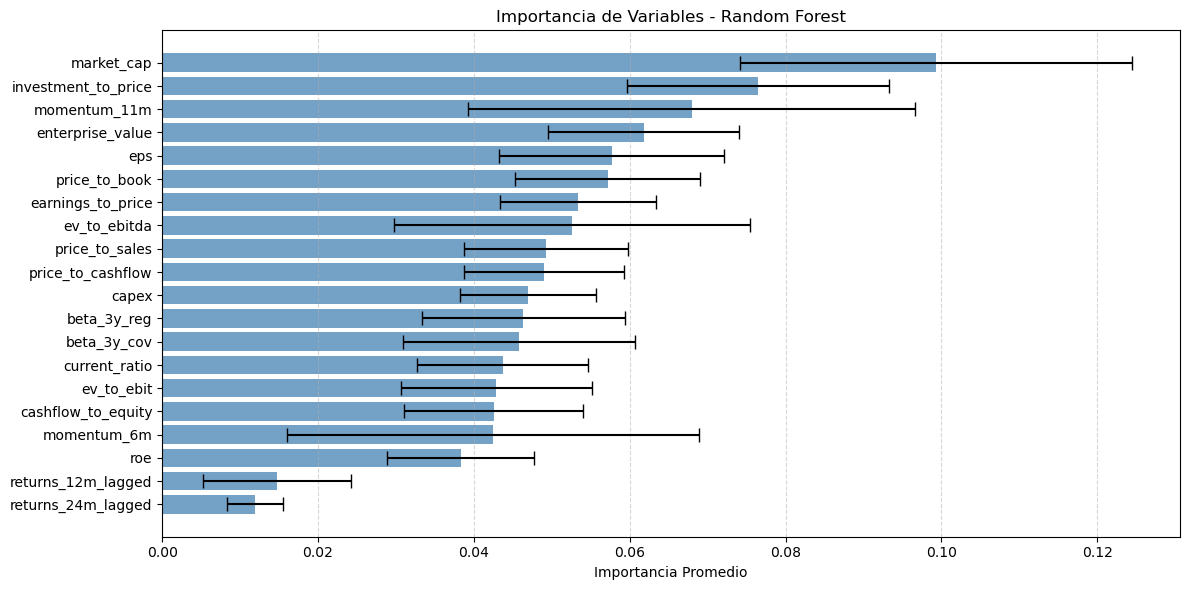

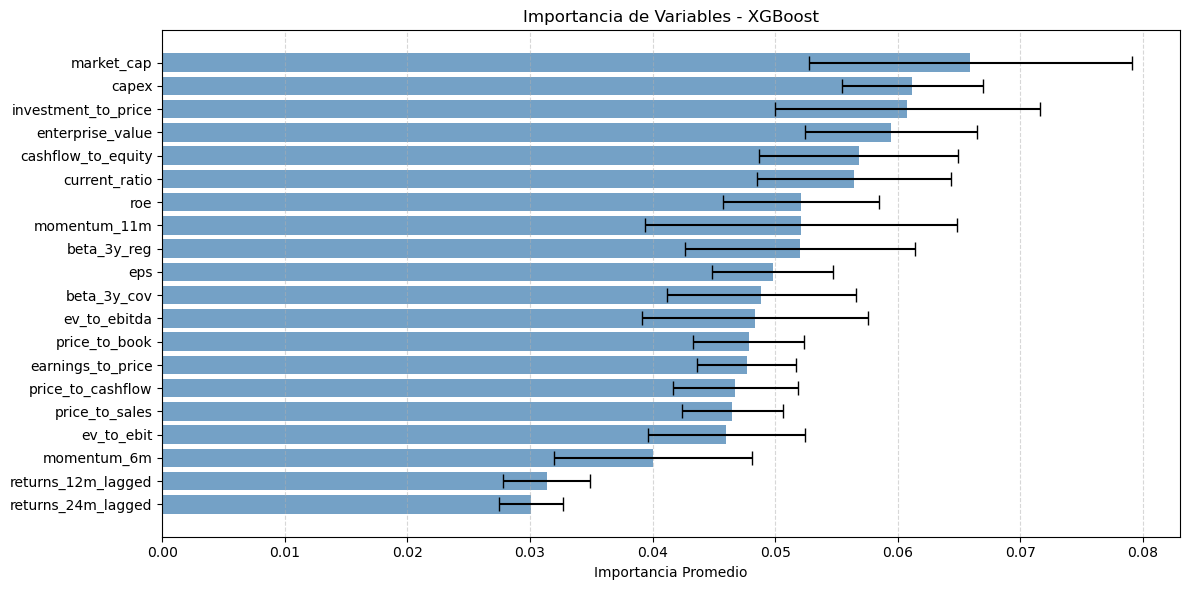

In [68]:
# 1. Consolidar importancias por modelo
df_imp_dt = consolidar_importancias(importancias_dt, features_finales)
df_imp_rf = consolidar_importancias(importancias_rf, features_finales)
df_imp_xgb = consolidar_importancias(importancias_xgb, features_finales)

# 2. Visualizar y (opcionalmente) guardar los gráficos de importancia
guardar_graficos = False  # Cambia a True para guardar los gráficos como PNG

plot_importancias_con_error(df_imp_dt, "Decision Tree", guardar=guardar_graficos)
plot_importancias_con_error(df_imp_rf, "Random Forest", guardar=guardar_graficos)
plot_importancias_con_error(df_imp_xgb, "XGBoost", guardar=guardar_graficos)


### 9.3. VISUALIZACIÓN TEMPORAL DE IMPORTANCIA DE VARIABLES

Se implementa la generación de gráficos que muestran la evolución temporal de la importancia de cada variable en los modelos evaluados. Esta etapa corresponde a la ejecución visual del análisis detallado en la sección anterior.

1) <u>Configuración del guardado de gráficos</u>:  
Se establece el parámetro `guardar_graficos_grid`, que determina si los gráficos serán almacenados como archivos PNG. Su valor predeterminado es `False`, aunque puede ajustarse a `True` si se requiere conservar las visualizaciones para documentación o análisis posteriores.

2) <u>Ejecución del análisis por modelo</u>:  
Se aplica la función `plot_importancia_por_feature` para cada uno de los modelos (`Decision Tree`, `Random Forest`, `XGBoost`). El procedimiento incluye trazabilidad mediante mensajes en consola que indican el modelo en proceso y el estado del análisis.

Cada llamada a la función recibe como entrada las importancias por rebalanceo, las fechas correspondientes y el identificador del modelo, generando una grilla de subgráficos que facilita la interpretación visual comparada entre variables a lo largo del tiempo.


Elaborando gráficos de evolución temporal de la importancia de features por modelo...




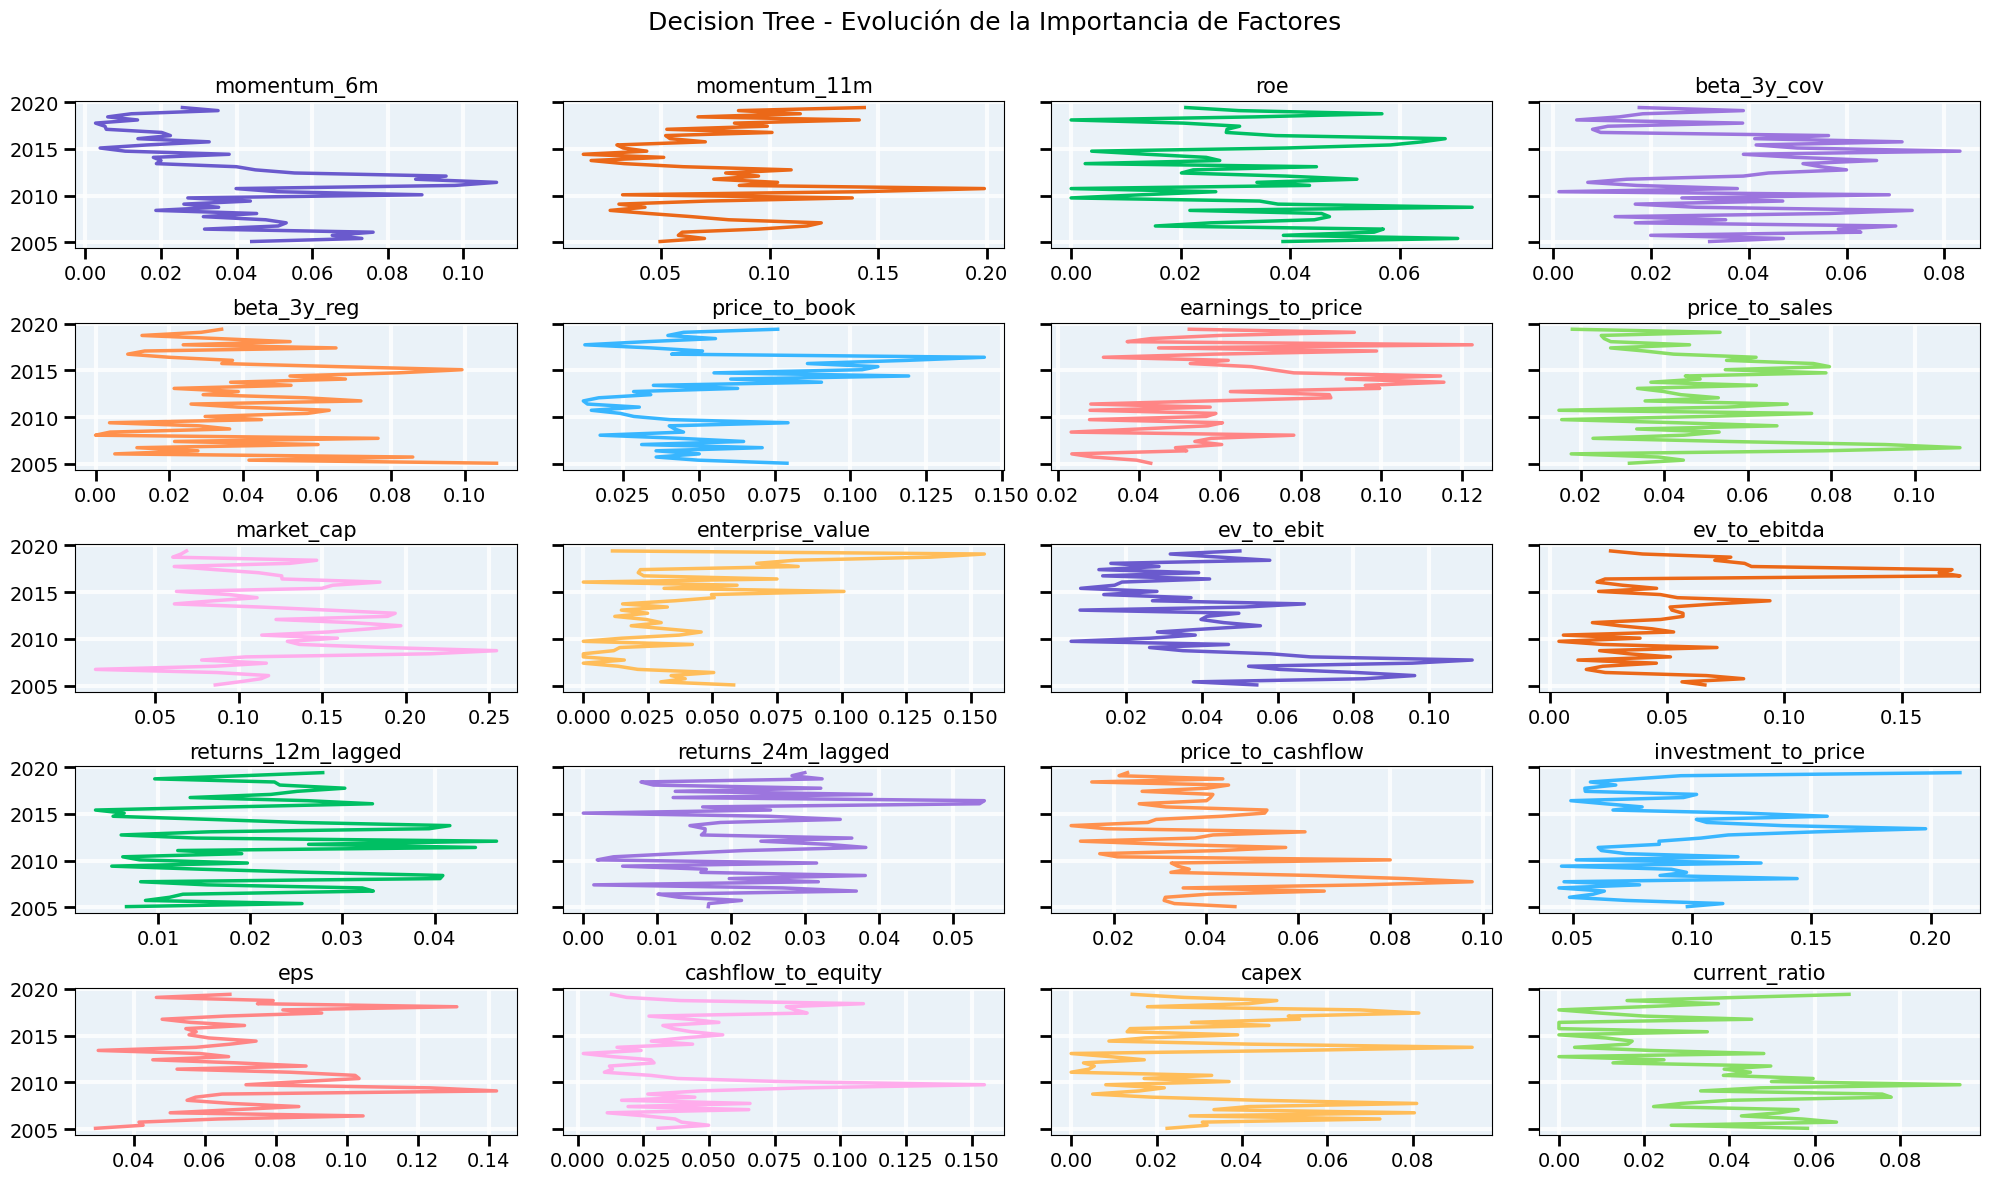

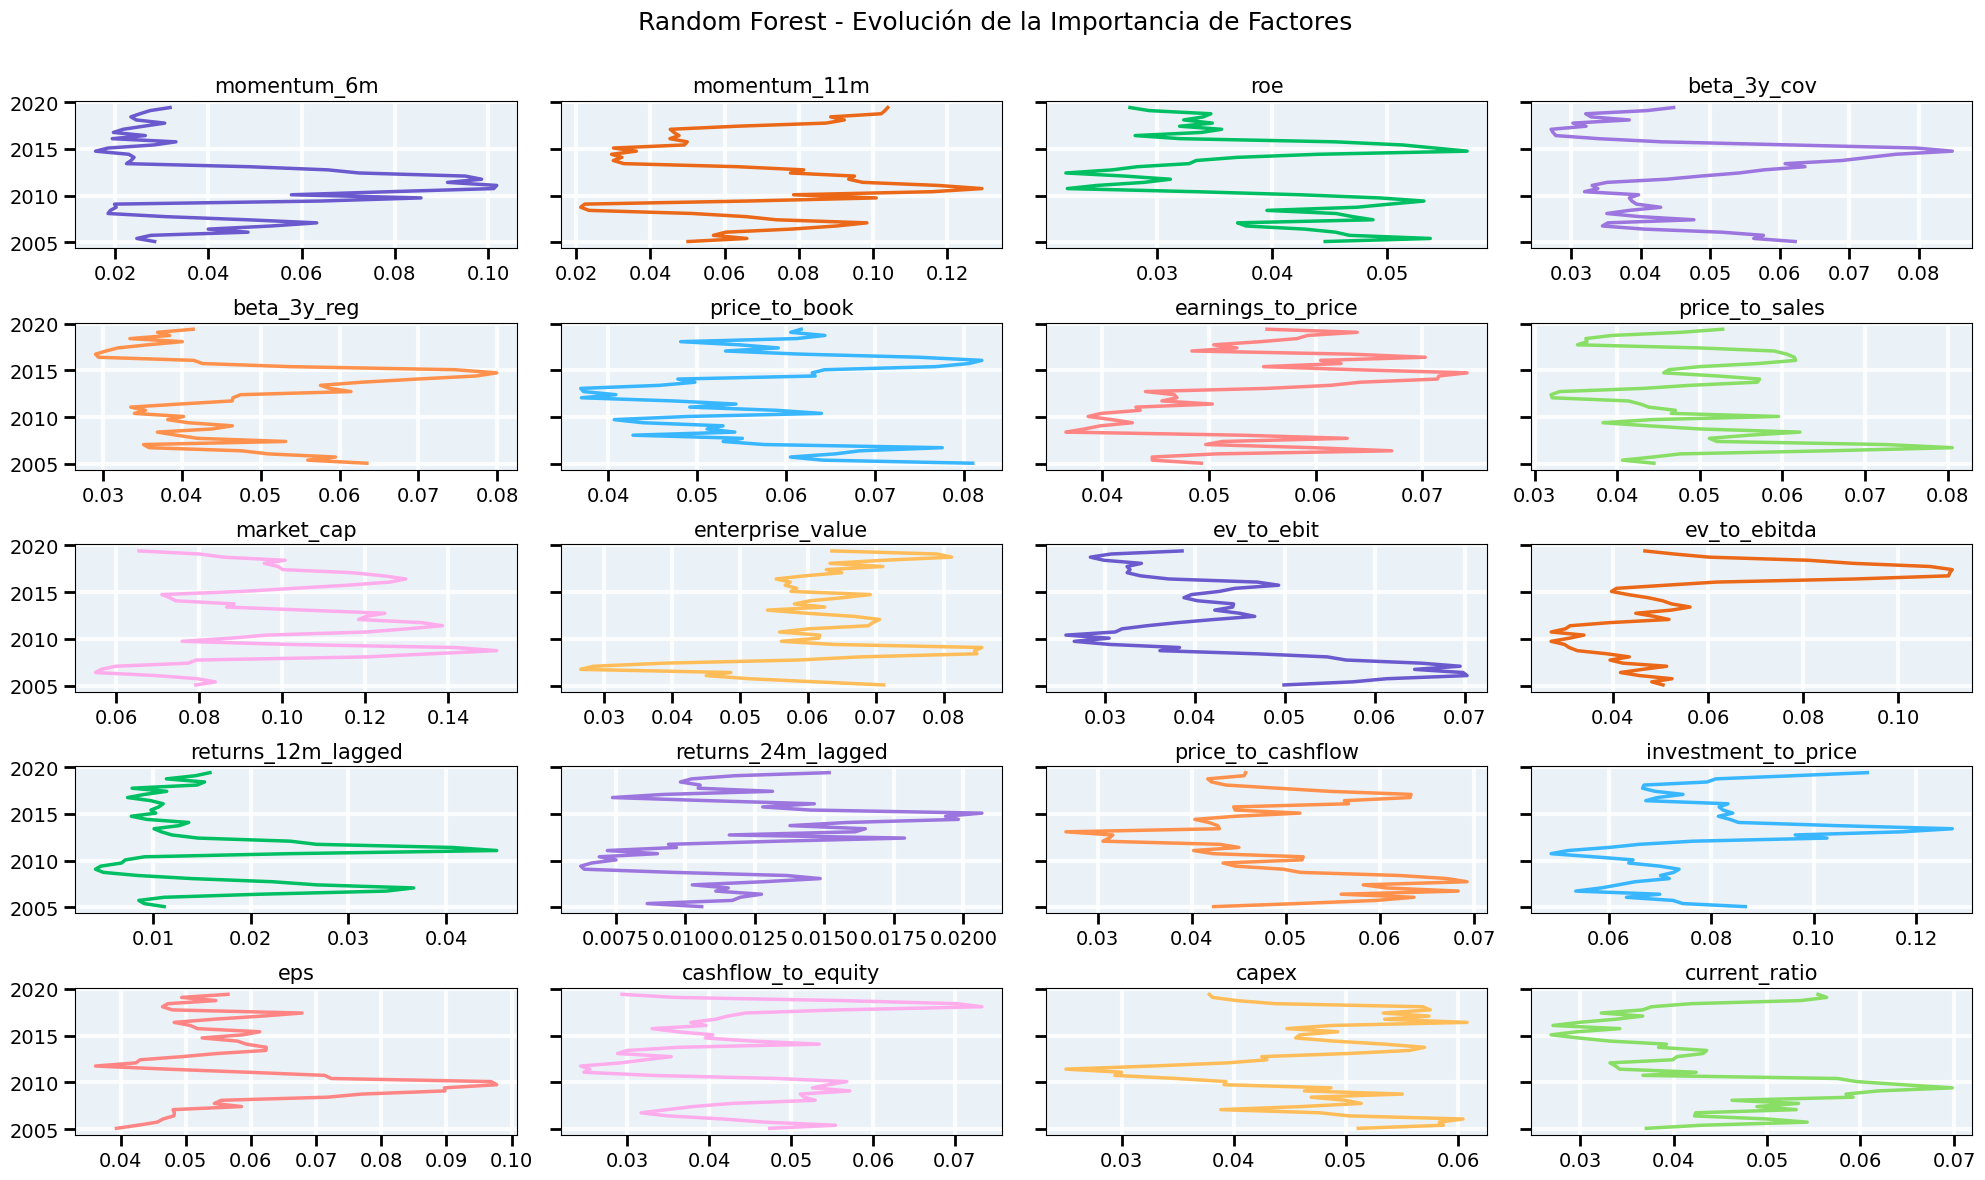

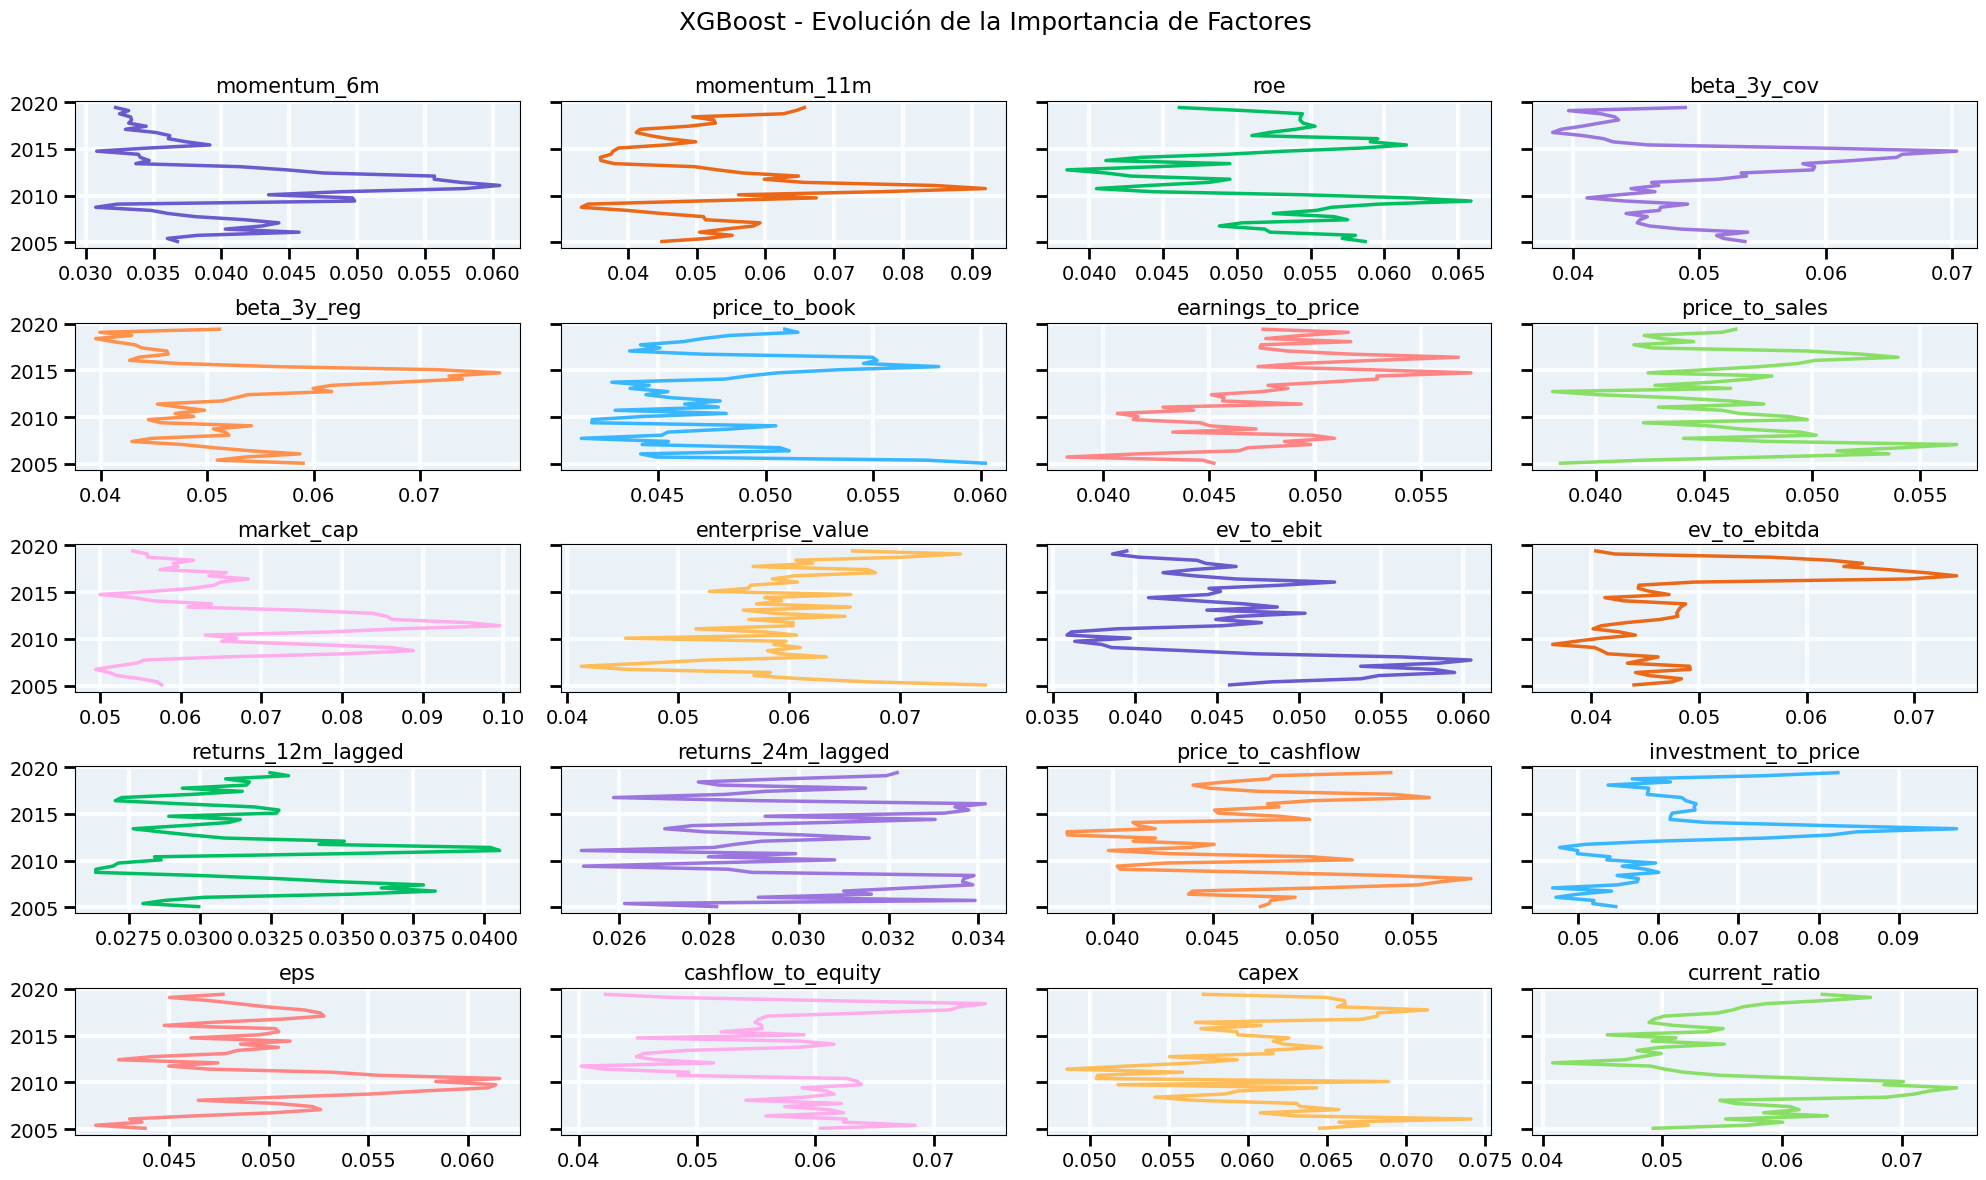

In [70]:
# 1. Configuración del guardado de gráficos
guardar_graficos_grid = False  # Cambia a True para guardar los gráficos

# Ejecución del análisis por modelo y visualización
print("Elaborando gráficos de evolución temporal de la importancia de features por modelo...")
print("\n")  # Separador visual
plot_importancia_por_feature(importancias_dt, rebalance_dates_dt, features_finales, "Decision Tree", guardar=guardar_graficos_grid)
print("\n")
plot_importancia_por_feature(importancias_rf, rebalance_dates_rf, features_finales, "Random Forest", guardar=guardar_graficos_grid)
print("\n")
plot_importancia_por_feature(importancias_xgb, rebalance_dates_xgb, features_finales, "XGBoost", guardar=guardar_graficos_grid)


In [71]:
# Checkpoint Final